<a href="https://colab.research.google.com/github/acse-2020/acse2020-acse9-finalreport-acse-jaq15/blob/main/notebooks/CNN/CNN_Corn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

The cells below handle all the necessary imports to run our models, making use of the public repo feeder_repo, linked <!-- [Text](link) -->
[here](https://github.com/acse-jaq15/feeder_repo).

In [1]:
# clone the feeder repo to get data_reader module and financial time series data
!git clone https://github.com/acse-jaq15/feeder_repo.git

Cloning into 'feeder_repo'...
remote: Enumerating objects: 147, done.
remote: Counting objects: 100% (147/147), done.
remote: Compressing objects: 100% (142/142), done.
remote: Total 147 (delta 71), reused 6 (delta 2), pack-reused 0
Receiving objects: 100% (147/147), 120.19 KiB | 3.25 MiB/s, done.
Resolving deltas: 100% (71/71), done.


In [2]:
# using '%' to enforce a permanent change of directory
%cd feeder_repo/

/content/feeder_repo


In [3]:
# checking contents listed correctly, should read:
# baseline_model.py data data_reader.py LICENSE README.md security_plotter.py
!ls

base_model.py  data  data_reader.py  LICENSE  README.md  security_plotter.py


In [4]:
import math
import sys
import keras
import os
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers import *
from keras.utils.layer_utils import count_params
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, Callback
from keras.optimizers import RMSprop, SGD, Adam, Nadam
from keras.initializers import random_normal

In [5]:
# appending path with 'feeder_repo' string
sys.path.append('feeder_repo')

# import Data_Reader class from data_reader module
from feeder_repo.data_reader import Data_Reader
# import Baseline_Model class from base_model module
from feeder_repo.base_model import Base_Model
# import Security_Plotter class from security_plotter module
from feeder_repo.security_plotter import Security_Plotter

In [6]:
# checking if the notebook is running on a GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Tue Jul 20 17:36:51 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Handling the data
Here the Data_Reader class is used to read the time series data and extract training, test and validation sets, along with the relevant X and y values.

In [7]:
# storing the file to be read as a string
in_str = 'Corn'
# storing the year of the time series to be used as test data
in_yr = 2019
# creating a variable to store the model name
model_str = 'CNN'
# setting our window_length to be 30 days
window_len = 30

In [8]:
# creating an instance of Data_Reader class
in_data = Data_Reader(in_str, in_yr)
# calling class method extract_train_test to generate training and test datasets
in_data.extract_train_test()
# calling class method extract_xy to generate X and y training and test datasets
in_data.extract_xy(window_len)

# assigning X_train and y_train
X_train = in_data.X_train
y_train = in_data.y_train

# assigning X_test and y_test
X_test = in_data.X_test
y_test = in_data.y_test

# assigning X_val_train and y_val_train
X_val_train = in_data.X_val_train
y_val_train = in_data.y_val_train

# assigning X_val_test and y_val_test
X_val_test = in_data.X_val_test
y_val_test = in_data.y_val_test

# Setting up wandb itegration
Here wandb is used to perform hyperparameter tuning.

In [ ]:
# installing the wandb library and importing
%pip install wandb -q
import wandb
from wandb.keras import WandbCallback

     |████████████████████████████████| 1.8MB 8.3MB/s 
     |████████████████████████████████| 143kB 52.8MB/s 
     |████████████████████████████████| 174kB 55.7MB/s 
     |████████████████████████████████| 102kB 13.3MB/s 
     |████████████████████████████████| 143kB 52.4MB/s 
     |████████████████████████████████| 71kB 8.4MB/s 
ERROR: requests 2.23.0 has requirement urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you'll have urllib3 1.26.6 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.


In [ ]:
!pip install wandb -qq

In [ ]:
# logging in so the hyperparameter tunings sweeps can be saved
!wandb login

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.6) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
# configuring the sweep, making use of a random search methodology
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'mse',
      'goal': 'minimize'   
    },
    'parameters': {
        'epochs': {
            'values': [50, 100, 200]
        },
        'batch_size': {
            'values': [128, 64, 32]
        },
        'learning_rate': {
            'values': [0.005, 0.001, 0.0005]
        },
        'optimizer': {
            'values': ['adam', 'nadam', 'rmsprop']
        },
        'activation': {
            'values': ['selu', 'relu']
        }
    }
}

In [ ]:
# wandb calls this training function to run through the hyperparameter search
def train():
    # default values for searching
    config_defaults = {
        'epochs': 100,
        'batch_size': 32,
        'learning_rate': 0.005,
        'optimizer': 'adam',
        'activation': 'tanh',
        'momentum': 0.9,
        'seed': 42
    }

    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config

    # setting keras model to sequential mode
    model = Sequential()

    # layer 1
    model.add(Conv1D(filters=128, kernel_size=2, activation=config.activation, input_shape=(window_len, 1)))
    # layer 2
    model.add(Conv1D(filters=64, kernel_size=2, activation=config.activation))
    # layer 3
    model.add(MaxPooling1D(pool_size=2))
    # layer 4
    model.add(Flatten())
    # layer 5
    model.add(Dense(1))

    # Define the optimizer
    if config.optimizer=='sgd':
      optimizer = SGD(learning_rate=config.learning_rate, decay=1e-5, momentum=config.momentum, nesterov=True)
    elif config.optimizer=='rmsprop':
      optimizer = RMSprop(learning_rate=config.learning_rate, decay=1e-5)
    elif config.optimizer=='adam':
      optimizer = Adam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
    elif config.optimizer=='nadam':
      optimizer = Nadam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

    model.compile(loss = "mean_squared_error", optimizer=optimizer, metrics=['mean_squared_error', 'mean_absolute_error'])

    model.fit(X_val_train, y_val_train, batch_size=config.batch_size,
              epochs=config.epochs,
              validation_data=(X_val_test, y_val_test),
              callbacks=[WandbCallback(validation_data=(X_val_test, y_val_test)),
                          EarlyStopping(patience=10, restore_best_weights=True)])

In [ ]:
# setting up our sweep_id
sweep_id = wandb.sweep(sweep_config, project='ACSE_9_'+model_str)

Create sweep with ID: h3iq5sjb
Sweep URL: https://wandb.ai/acse-jaq15/ACSE_9_CNN/sweeps/h3iq5sjb


In [ ]:
# initialising a new sweep
wandb.agent(sweep_id, train, project='ACSE_9_'+model_str)

wandb: Agent Starting Run: 95x0iwsl with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam
wandb: Currently logged in as: acse-jaq15 (use `wandb login --relogin` to force relogin)


Epoch 1/50
16/16 [==============================] - 29s 45ms/step - loss: 0.0820 - mean_squared_error: 0.0820 - mean_absolute_error: 0.2094 - val_loss: 0.0106 - val_mean_squared_error: 0.0106 - val_mean_absolute_error: 0.0830
Epoch 2/50
16/16 [==============================] - 0s 6ms/step - loss: 0.0051 - mean_squared_error: 0.0051 - mean_absolute_error: 0.0566 - val_loss: 0.0088 - val_mean_squared_error: 0.0088 - val_mean_absolute_error: 0.0751
Epoch 3/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - mean_absolute_error: 0.0431 - val_loss: 0.0110 - val_mean_squared_error: 0.0110 - val_mean_absolute_error: 0.0824
Epoch 4/50
16/16 [==============================] - 0s 5ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0348 - val_loss: 0.0094 - val_mean_squared_error: 0.0094 - val_mean_absolute_error: 0.0767
Epoch 5/50
16/16 [==============================] - 0s 6ms/step - loss: 0.0021 - mean_squared_error: 0

epoch,49
loss,0.00042
mean_squared_error,0.00042
mean_absolute_error,0.01538
val_loss,0.00175
val_mean_squared_error,0.00175
val_mean_absolute_error,0.03328
_runtime,42
_timestamp,1626533155
_step,49
best_val_loss,0.00169


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆█▇▆▅▅▄▂▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁
val_mean_squared_error,█▆█▇▆▅▅▄▂▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁
val_mean_absolute_error,█▇█▇▇▆▆▅▃▃▃▂▂▂▁▁▁▁▁▂▁▂▁▂▂▁▁▂▃▁▁▁▁▂▁▁▁▁▁▁
_runtime,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: c1c0v050 with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/50
32/32 [==============================] - 1s 17ms/step - loss: 0.3624 - mean_squared_error: 0.3624 - mean_absolute_error: 0.3588 - val_loss: 0.0074 - val_mean_squared_error: 0.0074 - val_mean_absolute_error: 0.0690
Epoch 2/50
32/32 [==============================] - 0s 5ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0468 - val_loss: 0.0062 - val_mean_squared_error: 0.0062 - val_mean_absolute_error: 0.0620
Epoch 3/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0281 - val_loss: 0.0040 - val_mean_squared_error: 0.0040 - val_mean_absolute_error: 0.0509
Epoch 4/50
32/32 [==============================] - 0s 6ms/step - loss: 9.0813e-04 - mean_squared_error: 9.0813e-04 - mean_absolute_error: 0.0219 - val_loss: 0.0032 - val_mean_squared_error: 0.0032 - val_mean_absolute_error: 0.0463
Epoch 5/50
32/32 [==============================] - 0s 5ms/step - loss: 7.6174e-04 - mean_squar

epoch,37
loss,0.00071
mean_squared_error,0.00071
mean_absolute_error,0.02027
val_loss,0.00157
val_mean_squared_error,0.00157
val_mean_absolute_error,0.03214
_runtime,11
_timestamp,1626533191
_step,37
best_val_loss,0.00136


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▅▄▄▃▂▂▂▂▂▁▁▁▂▁▁▁▁▂▃▁▁▂▁▁▁▁▁▁▁▁▁▂▁▁▁▂
_runtime,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██████
_timestamp,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██████
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 4t1bkstd with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/100
32/32 [==============================] - 1s 16ms/step - loss: 0.0715 - mean_squared_error: 0.0715 - mean_absolute_error: 0.1462 - val_loss: 0.0090 - val_mean_squared_error: 0.0090 - val_mean_absolute_error: 0.0762
Epoch 2/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0054 - mean_squared_error: 0.0054 - mean_absolute_error: 0.0560 - val_loss: 0.0212 - val_mean_squared_error: 0.0212 - val_mean_absolute_error: 0.1193
Epoch 3/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0047 - mean_squared_error: 0.0047 - mean_absolute_error: 0.0514 - val_loss: 0.0091 - val_mean_squared_error: 0.0091 - val_mean_absolute_error: 0.0753
Epoch 4/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0043 - mean_squared_error: 0.0043 - mean_absolute_error: 0.0490 - val_loss: 0.0064 - val_mean_squared_error: 0.0064 - val_mean_absolute_error: 0.0648
Epoch 5/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0037 - mean_squared_erro

epoch,31
loss,0.00142
mean_squared_error,0.00142
mean_absolute_error,0.0299
val_loss,0.00671
val_mean_squared_error,0.00671
val_mean_absolute_error,0.06485
_runtime,10
_timestamp,1626533212
_step,31
best_val_loss,0.00258


epoch,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███
loss,█▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▄▄▃▃▃▃▂▂▃▂▂▂▁▂▂▂▁▂▂▁▂▂▁▁▁▂▂▁▁
val_loss,▃█▃▂▂▃▃▂▂▄▄▂▂▄▃▁▂▃▂▁▁▁▁▁▂▁▁▂▁▁▂▃
val_mean_squared_error,▃█▃▂▂▃▃▂▂▄▄▂▂▄▃▁▂▃▂▁▁▁▁▁▂▁▁▂▁▁▂▃
val_mean_absolute_error,▄█▄▃▃▃▃▂▂▄▅▂▂▄▃▁▃▄▂▁▁▁▁▁▂▂▁▂▁▁▂▃
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███


wandb: Agent Starting Run: tvsljm6w with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/50
16/16 [==============================] - 1s 26ms/step - loss: 0.1140 - mean_squared_error: 0.1140 - mean_absolute_error: 0.2548 - val_loss: 0.0151 - val_mean_squared_error: 0.0151 - val_mean_absolute_error: 0.1033
Epoch 2/50
16/16 [==============================] - 0s 5ms/step - loss: 0.0074 - mean_squared_error: 0.0074 - mean_absolute_error: 0.0669 - val_loss: 0.0162 - val_mean_squared_error: 0.0162 - val_mean_absolute_error: 0.1049
Epoch 3/50
16/16 [==============================] - 0s 5ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - mean_absolute_error: 0.0494 - val_loss: 0.0103 - val_mean_squared_error: 0.0103 - val_mean_absolute_error: 0.0815
Epoch 4/50
16/16 [==============================] - 0s 5ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - mean_absolute_error: 0.0371 - val_loss: 0.0094 - val_mean_squared_error: 0.0094 - val_mean_absolute_error: 0.0773
Epoch 5/50
16/16 [==============================] - 0s 6ms/step - loss: 0.0024 - mean_squared_error: 0.

epoch,49
loss,0.00039
mean_squared_error,0.00039
mean_absolute_error,0.01432
val_loss,0.00178
val_mean_squared_error,0.00178
val_mean_absolute_error,0.03376
_runtime,10
_timestamp,1626533229
_step,49
best_val_loss,0.00178


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▇█▅▅▄▄▄▄▃▃▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▇█▅▅▄▄▄▄▃▃▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,██▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇█████
_timestamp,▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇█████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: tlxm9509 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/50
8/8 [==============================] - 1s 55ms/step - loss: 0.2254 - mean_squared_error: 0.2254 - mean_absolute_error: 0.3810 - val_loss: 0.0255 - val_mean_squared_error: 0.0255 - val_mean_absolute_error: 0.1350
Epoch 2/50
8/8 [==============================] - 0s 7ms/step - loss: 0.0247 - mean_squared_error: 0.0247 - mean_absolute_error: 0.1372 - val_loss: 0.0205 - val_mean_squared_error: 0.0205 - val_mean_absolute_error: 0.1192
Epoch 3/50
8/8 [==============================] - 0s 7ms/step - loss: 0.0065 - mean_squared_error: 0.0065 - mean_absolute_error: 0.0617 - val_loss: 0.0133 - val_mean_squared_error: 0.0133 - val_mean_absolute_error: 0.0911
Epoch 4/50
8/8 [==============================] - 0s 7ms/step - loss: 0.0085 - mean_squared_error: 0.0085 - mean_absolute_error: 0.0721 - val_loss: 0.0152 - val_mean_squared_error: 0.0152 - val_mean_absolute_error: 0.1018
Epoch 5/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - mea

epoch,49
loss,0.00049
mean_squared_error,0.00049
mean_absolute_error,0.01624
val_loss,0.00244
val_mean_squared_error,0.00244
val_mean_absolute_error,0.04008
_runtime,8
_timestamp,1626533245
_step,49
best_val_loss,0.00244


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▄▅▄▄▄▄▃▄▃▃▃▃▃▃▃▂▂▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▄▅▄▄▄▄▃▄▃▃▃▃▃▃▃▂▂▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▅▆▅▄▄▄▄▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▃▃▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆██████
_timestamp,▁▁▁▁▁▃▃▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆██████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: bqolbebj with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/100
32/32 [==============================] - 1s 15ms/step - loss: 0.0559 - mean_squared_error: 0.0559 - mean_absolute_error: 0.1376 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - val_mean_absolute_error: 0.0804
Epoch 2/100
32/32 [==============================] - 0s 4ms/step - loss: 0.0049 - mean_squared_error: 0.0049 - mean_absolute_error: 0.0537 - val_loss: 0.0113 - val_mean_squared_error: 0.0113 - val_mean_absolute_error: 0.0847
Epoch 3/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0437 - val_loss: 0.0081 - val_mean_squared_error: 0.0081 - val_mean_absolute_error: 0.0707
Epoch 4/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0417 - val_loss: 0.0062 - val_mean_squared_error: 0.0062 - val_mean_absolute_error: 0.0630
Epoch 5/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0025 - mean_squared_erro

epoch,58
loss,0.00082
mean_squared_error,0.00082
mean_absolute_error,0.022
val_loss,0.00225
val_mean_squared_error,0.00225
val_mean_absolute_error,0.03776
_runtime,16
_timestamp,1626533268
_step,58
best_val_loss,0.00194


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_loss,▇█▆▄▄▃▃▄▆▃▆▃▃▃▂▄▂▂▂▁▄▂▁▂▂▁▃▂▁▃▁▂▂▁▁▁▁▁▁▁
val_mean_squared_error,▇█▆▄▄▃▃▄▆▃▆▃▃▃▂▄▂▂▂▁▄▂▁▂▂▁▃▂▁▃▁▂▂▁▁▁▁▁▁▁
val_mean_absolute_error,▇█▆▄▅▄▃▅▆▃▇▄▄▄▃▅▃▂▂▁▅▂▁▃▃▁▃▂▁▄▁▃▂▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 0i4ffcw5 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/50
32/32 [==============================] - 2s 25ms/step - loss: 0.1194 - mean_squared_error: 0.1194 - mean_absolute_error: 0.2142 - val_loss: 0.0148 - val_mean_squared_error: 0.0148 - val_mean_absolute_error: 0.0922
Epoch 2/50
32/32 [==============================] - 0s 5ms/step - loss: 0.0119 - mean_squared_error: 0.0119 - mean_absolute_error: 0.0846 - val_loss: 0.0100 - val_mean_squared_error: 0.0100 - val_mean_absolute_error: 0.0809
Epoch 3/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0092 - mean_squared_error: 0.0092 - mean_absolute_error: 0.0722 - val_loss: 0.0073 - val_mean_squared_error: 0.0073 - val_mean_absolute_error: 0.0676
Epoch 4/50
32/32 [==============================] - 0s 5ms/step - loss: 0.0100 - mean_squared_error: 0.0100 - mean_absolute_error: 0.0744 - val_loss: 0.0076 - val_mean_squared_error: 0.0076 - val_mean_absolute_error: 0.0685
Epoch 5/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0045 - mean_squared_error: 0.

epoch,49
loss,0.00143
mean_squared_error,0.00143
mean_absolute_error,0.02903
val_loss,0.00269
val_mean_squared_error,0.00269
val_mean_absolute_error,0.04155
_runtime,14
_timestamp,1626533290
_step,49
best_val_loss,0.00229


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁
val_loss,█▅▄▄▅▄▃▅▃▄▇▃▄▅▄▃▃▄▂▅▂▂▃▂▃▇▂▁▃▂▄▁▆▃▁▄▁▂▁▁
val_mean_squared_error,█▅▄▄▅▄▃▅▃▄▇▃▄▅▄▃▃▄▂▅▂▂▃▂▃▇▂▁▃▂▄▁▆▃▁▄▁▂▁▁
val_mean_absolute_error,█▇▅▅▆▅▄▅▄▅█▄▄▅▅▄▄▅▃▇▃▃▃▃▃▇▂▂▃▃▅▂▇▄▁▅▁▂▂▁
_runtime,▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇████
_timestamp,▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: jh5w6i98 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 2s 56ms/step - loss: 1.0621 - mean_squared_error: 1.0621 - mean_absolute_error: 0.6835 - val_loss: 0.0620 - val_mean_squared_error: 0.0620 - val_mean_absolute_error: 0.2060
Epoch 2/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0419 - mean_squared_error: 0.0419 - mean_absolute_error: 0.1607 - val_loss: 0.0074 - val_mean_squared_error: 0.0074 - val_mean_absolute_error: 0.0688
Epoch 3/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - mean_absolute_error: 0.0473 - val_loss: 0.0137 - val_mean_squared_error: 0.0137 - val_mean_absolute_error: 0.0892
Epoch 4/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0207 - mean_squared_error: 0.0207 - mean_absolute_error: 0.1190 - val_loss: 0.0065 - val_mean_squared_error: 0.0065 - val_mean_absolute_error: 0.0649
Epoch 5/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0026 - mean_squared_error: 0.0026 

epoch,40
loss,0.00622
mean_squared_error,0.00622
mean_absolute_error,0.06544
val_loss,0.00479
val_mean_squared_error,0.00479
val_mean_absolute_error,0.05421
_runtime,8
_timestamp,1626533306
_step,40
best_val_loss,0.00269


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▂▁▂▂▁▂▁▂▇▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂
val_loss,▃▁▁▁▁▁▁▁▁▁█▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▃▁▁▁▁▁▁▁▁▁█▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▄▂▂▁▁▂▁▂▁▁█▆▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▃▃▃▃▃▃▃▃▃▃▃▃▆▆▆▆▆▆▆▆▆▆▆▆████████████
_timestamp,▁▁▁▁▃▃▃▃▃▃▃▃▃▃▃▃▆▆▆▆▆▆▆▆▆▆▆▆████████████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██


wandb: Agent Starting Run: lo4rklty with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
32/32 [==============================] - 1s 17ms/step - loss: 0.1332 - mean_squared_error: 0.1332 - mean_absolute_error: 0.2760 - val_loss: 0.0144 - val_mean_squared_error: 0.0144 - val_mean_absolute_error: 0.1013
Epoch 2/50
32/32 [==============================] - 0s 5ms/step - loss: 0.0043 - mean_squared_error: 0.0043 - mean_absolute_error: 0.0495 - val_loss: 0.0121 - val_mean_squared_error: 0.0121 - val_mean_absolute_error: 0.0888
Epoch 3/50
32/32 [==============================] - 0s 5ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0347 - val_loss: 0.0118 - val_mean_squared_error: 0.0118 - val_mean_absolute_error: 0.0867
Epoch 4/50
32/32 [==============================] - 0s 5ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0344 - val_loss: 0.0112 - val_mean_squared_error: 0.0112 - val_mean_absolute_error: 0.0837
Epoch 5/50
32/32 [==============================] - 0s 5ms/step - loss: 0.0021 - mean_squared_error: 0.

epoch,49
loss,0.00036
mean_squared_error,0.00036
mean_absolute_error,0.01383
val_loss,0.00175
val_mean_squared_error,0.00175
val_mean_absolute_error,0.03346
_runtime,15
_timestamp,1626533330
_step,49
best_val_loss,0.00175


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▇▆▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▇▆▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▆▆▅▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: sqbal4vg with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/100
32/32 [==============================] - 1s 15ms/step - loss: 0.0963 - mean_squared_error: 0.0963 - mean_absolute_error: 0.1737 - val_loss: 0.0168 - val_mean_squared_error: 0.0168 - val_mean_absolute_error: 0.1057
Epoch 2/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0122 - mean_squared_error: 0.0122 - mean_absolute_error: 0.0862 - val_loss: 0.0082 - val_mean_squared_error: 0.0082 - val_mean_absolute_error: 0.0728
Epoch 3/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0043 - mean_squared_error: 0.0043 - mean_absolute_error: 0.0459 - val_loss: 0.0057 - val_mean_squared_error: 0.0057 - val_mean_absolute_error: 0.0608
Epoch 4/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0050 - mean_squared_error: 0.0050 - mean_absolute_error: 0.0564 - val_loss: 0.0055 - val_mean_squared_error: 0.0055 - val_mean_absolute_error: 0.0595
Epoch 5/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0032 - mean_squared_erro

epoch,40
loss,0.00127
mean_squared_error,0.00127
mean_absolute_error,0.02446
val_loss,0.00153
val_mean_squared_error,0.00153
val_mean_absolute_error,0.03022
_runtime,12
_timestamp,1626533360
_step,40
best_val_loss,0.00142


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
loss,█▃▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▄▄▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▁▂▁▁▂▁▂▁▂▁▁▁▁▁
val_loss,█▄▃▃▅▆▂▂▁▃▁▄▁▁▁▁▂▁▂▁▁▁▁▁▂▃▁▁▁▂▁▁▁▁▁▁▁▁▂▁
val_mean_squared_error,█▄▃▃▅▆▂▂▁▃▁▄▁▁▁▁▂▁▂▁▁▁▁▁▂▃▁▁▁▂▁▁▁▁▁▁▁▁▂▁
val_mean_absolute_error,█▅▄▄▆▆▂▂▂▄▂▆▁▁▁▂▂▁▂▁▁▁▁▁▃▄▁▁▂▂▁▁▁▁▁▁▂▂▃▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██


wandb: Agent Starting Run: 56wulty4 with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 2s 31ms/step - loss: 0.1003 - mean_squared_error: 0.1003 - mean_absolute_error: 0.1984 - val_loss: 0.0114 - val_mean_squared_error: 0.0114 - val_mean_absolute_error: 0.0886
Epoch 2/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - mean_absolute_error: 0.0378 - val_loss: 0.0117 - val_mean_squared_error: 0.0117 - val_mean_absolute_error: 0.0874
Epoch 3/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0458 - val_loss: 0.0118 - val_mean_squared_error: 0.0118 - val_mean_absolute_error: 0.0863
Epoch 4/100
16/16 [==============================] - 0s 12ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0456 - val_loss: 0.0070 - val_mean_squared_error: 0.0070 - val_mean_absolute_error: 0.0682
Epoch 5/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0024 - mean_squared_err

wandb: Processing terminal ouput (stdout)...
wandb: Done.


epoch,80
loss,0.00078
mean_squared_error,0.00078
mean_absolute_error,0.02163
val_loss,0.00191
val_mean_squared_error,0.00191
val_mean_absolute_error,0.0351
_runtime,18
_timestamp,1626533386
_step,80
best_val_loss,0.00161


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▂▃▃▂▂▄▃▂▃▂▂▂▂▁▂▂▂▁▂▂▁▁▂▂▁▁▁▁▁▁▂▁▂▁▁▁▂
val_loss,▆▆▅▃█▃▂▂▂▂▂▂▂▂▂▃▂▂▂▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▆▆▅▃█▃▂▂▂▂▂▂▂▂▂▃▂▂▂▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▇▆▅▄█▃▃▃▃▃▃▂▂▂▂▃▂▂▂▃▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇█
_timestamp,▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇█
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vonw0gkd with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/200
32/32 [==============================] - 1s 15ms/step - loss: 0.0476 - mean_squared_error: 0.0476 - mean_absolute_error: 0.1111 - val_loss: 0.0379 - val_mean_squared_error: 0.0379 - val_mean_absolute_error: 0.1683
Epoch 2/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0077 - mean_squared_error: 0.0077 - mean_absolute_error: 0.0630 - val_loss: 0.0086 - val_mean_squared_error: 0.0086 - val_mean_absolute_error: 0.0725
Epoch 3/200
32/32 [==============================] - 0s 5ms/step - loss: 0.0099 - mean_squared_error: 0.0099 - mean_absolute_error: 0.0732 - val_loss: 0.0053 - val_mean_squared_error: 0.0053 - val_mean_absolute_error: 0.0576
Epoch 4/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - mean_absolute_error: 0.0416 - val_loss: 0.0043 - val_mean_squared_error: 0.0043 - val_mean_absolute_error: 0.0529
Epoch 5/200
32/32 [==============================] - 0s 5ms/step - loss: 0.0041 - mean_squared_erro

epoch,46
loss,0.00073
mean_squared_error,0.00073
mean_absolute_error,0.02038
val_loss,0.00167
val_mean_squared_error,0.00167
val_mean_absolute_error,0.03181
_runtime,15
_timestamp,1626533428
_step,46
best_val_loss,0.00134


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▄▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▄▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▆▅▄▄▄▄▃▂▃▂▃▂▃▂▂▂▂▂▂▁▂▂▂▂▂▁▂▂▁▂▂▁▁▁▁▁▁▁
val_loss,█▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▂▂▃▂▃▂▂▁▁▁▁▂▁▁▁▁▂▁▁▂▁▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁
_runtime,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇█
_timestamp,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: g4ir3nt5 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/200
16/16 [==============================] - 1s 29ms/step - loss: 0.1057 - mean_squared_error: 0.1057 - mean_absolute_error: 0.2423 - val_loss: 0.0135 - val_mean_squared_error: 0.0135 - val_mean_absolute_error: 0.0969
Epoch 2/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0072 - mean_squared_error: 0.0072 - mean_absolute_error: 0.0644 - val_loss: 0.0191 - val_mean_squared_error: 0.0191 - val_mean_absolute_error: 0.1137
Epoch 3/200
16/16 [==============================] - 0s 6ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0499 - val_loss: 0.0129 - val_mean_squared_error: 0.0129 - val_mean_absolute_error: 0.0921
Epoch 4/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - mean_absolute_error: 0.0382 - val_loss: 0.0114 - val_mean_squared_error: 0.0114 - val_mean_absolute_error: 0.0859
Epoch 5/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0022 - mean_squared_erro

epoch,65
loss,0.00039
mean_squared_error,0.00039
mean_absolute_error,0.01437
val_loss,0.00208
val_mean_squared_error,0.00208
val_mean_absolute_error,0.03651
_runtime,14
_timestamp,1626533450
_step,65
best_val_loss,0.00169


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▆█▅▄▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▆█▅▄▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▇█▆▄▄▃▃▃▂▂▂▂▂▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 23ftbodc with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/50
32/32 [==============================] - 1s 16ms/step - loss: 0.1463 - mean_squared_error: 0.1463 - mean_absolute_error: 0.2403 - val_loss: 0.0582 - val_mean_squared_error: 0.0582 - val_mean_absolute_error: 0.2110
Epoch 2/50
32/32 [==============================] - 0s 5ms/step - loss: 0.0228 - mean_squared_error: 0.0228 - mean_absolute_error: 0.1153 - val_loss: 0.0097 - val_mean_squared_error: 0.0097 - val_mean_absolute_error: 0.0781
Epoch 3/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0098 - mean_squared_error: 0.0098 - mean_absolute_error: 0.0668 - val_loss: 0.0078 - val_mean_squared_error: 0.0078 - val_mean_absolute_error: 0.0712
Epoch 4/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0116 - mean_squared_error: 0.0116 - mean_absolute_error: 0.0801 - val_loss: 0.0081 - val_mean_squared_error: 0.0081 - val_mean_absolute_error: 0.0704
Epoch 5/50
32/32 [==============================] - 0s 5ms/step - loss: 0.0067 - mean_squared_error: 0.

epoch,49
loss,0.00213
mean_squared_error,0.00213
mean_absolute_error,0.03542
val_loss,0.00691
val_mean_squared_error,0.00691
val_mean_absolute_error,0.06507
_runtime,15
_timestamp,1626533503
_step,49
best_val_loss,0.0024


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▄▄▄▃▃▂▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▂▂▂▂▂▂▃▁▁▂▂▁▂▂▂▁▁▁▁▂▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▂
val_mean_squared_error,█▂▂▂▂▂▂▂▃▁▁▂▂▁▂▂▂▁▁▁▁▂▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▂
val_mean_absolute_error,█▃▂▂▃▂▂▂▄▂▂▂▂▂▃▂▂▂▂▁▁▂▂▁▁▂▁▁▁▂▂▁▁▂▂▁▁▁▂▂
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: u85dpnya with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/200
16/16 [==============================] - 2s 25ms/step - loss: 0.1581 - mean_squared_error: 0.1581 - mean_absolute_error: 0.2154 - val_loss: 0.0109 - val_mean_squared_error: 0.0109 - val_mean_absolute_error: 0.0886
Epoch 2/200
16/16 [==============================] - 0s 6ms/step - loss: 0.0055 - mean_squared_error: 0.0055 - mean_absolute_error: 0.0556 - val_loss: 0.0086 - val_mean_squared_error: 0.0086 - val_mean_absolute_error: 0.0738
Epoch 3/200
16/16 [==============================] - 0s 6ms/step - loss: 0.0096 - mean_squared_error: 0.0096 - mean_absolute_error: 0.0778 - val_loss: 0.0080 - val_mean_squared_error: 0.0080 - val_mean_absolute_error: 0.0728
Epoch 4/200
16/16 [==============================] - 0s 6ms/step - loss: 0.0070 - mean_squared_error: 0.0070 - mean_absolute_error: 0.0649 - val_loss: 0.0077 - val_mean_squared_error: 0.0077 - val_mean_absolute_error: 0.0711
Epoch 5/200
16/16 [==============================] - 0s 6ms/step - loss: 0.0071 - mean_squared_erro

epoch,54
loss,0.00086
mean_squared_error,0.00086
mean_absolute_error,0.02302
val_loss,0.00179
val_mean_squared_error,0.00179
val_mean_absolute_error,0.03287
_runtime,12
_timestamp,1626533539
_step,54
best_val_loss,0.00149


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▅▄▃▄▃▃▃▃▂▂▂▂▂▁▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▆▄▄▃▃▄▃▂▅▂▃▃▂▄▁▁▂▂▆▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁▂▂▁
val_mean_squared_error,█▆▆▄▄▃▃▄▃▂▅▂▃▃▂▄▁▁▂▂▆▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁▂▂▁
val_mean_absolute_error,█▆▆▅▄▄▄▄▃▃▅▃▄▄▃▅▂▂▂▃▇▂▂▁▂▂▁▂▁▁▁▁▁▁▂▂▁▂▂▁
_runtime,▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: kqyxitlh with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/200
8/8 [==============================] - 1s 52ms/step - loss: 0.2854 - mean_squared_error: 0.2854 - mean_absolute_error: 0.4329 - val_loss: 0.0124 - val_mean_squared_error: 0.0124 - val_mean_absolute_error: 0.0933
Epoch 2/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0176 - mean_squared_error: 0.0176 - mean_absolute_error: 0.1098 - val_loss: 0.0314 - val_mean_squared_error: 0.0314 - val_mean_absolute_error: 0.1507
Epoch 3/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0083 - mean_squared_error: 0.0083 - mean_absolute_error: 0.0738 - val_loss: 0.0127 - val_mean_squared_error: 0.0127 - val_mean_absolute_error: 0.0891
Epoch 4/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0091 - mean_squared_error: 0.0091 - mean_absolute_error: 0.0760 - val_loss: 0.0150 - val_mean_squared_error: 0.0150 - val_mean_absolute_error: 0.1009
Epoch 5/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0043 - mean_squared_error: 0.0043 

epoch,80
loss,0.00038
mean_squared_error,0.00038
mean_absolute_error,0.01414
val_loss,0.00197
val_mean_squared_error,0.00197
val_mean_absolute_error,0.03532
_runtime,12
_timestamp,1626533561
_step,80
best_val_loss,0.00184


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▇▇█▇▆▅▅▅▅▄▄▄▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▇▇█▇▆▅▅▅▅▄▄▄▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇█▇▆▆▆▅▅▄▄▄▄▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇█████
_timestamp,▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇█████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: k6l9bkj7 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/200
8/8 [==============================] - 1s 56ms/step - loss: 0.1918 - mean_squared_error: 0.1918 - mean_absolute_error: 0.3088 - val_loss: 0.0351 - val_mean_squared_error: 0.0351 - val_mean_absolute_error: 0.1438
Epoch 2/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0296 - mean_squared_error: 0.0296 - mean_absolute_error: 0.1407 - val_loss: 0.0107 - val_mean_squared_error: 0.0107 - val_mean_absolute_error: 0.0833
Epoch 3/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0110 - mean_squared_error: 0.0110 - mean_absolute_error: 0.0857 - val_loss: 0.0169 - val_mean_squared_error: 0.0169 - val_mean_absolute_error: 0.0991
Epoch 4/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0157 - mean_squared_error: 0.0157 - mean_absolute_error: 0.1060 - val_loss: 0.0158 - val_mean_squared_error: 0.0158 - val_mean_absolute_error: 0.0961
Epoch 5/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0170 - mean_squared_error: 0.0170 

epoch,70
loss,0.00275
mean_squared_error,0.00275
mean_absolute_error,0.03578
val_loss,0.00493
val_mean_squared_error,0.00493
val_mean_absolute_error,0.05512
_runtime,12
_timestamp,1626533582
_step,70
best_val_loss,0.00365


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▃▃▃▃▃▃▂▃▂▂▃▂▂▂▂▂▁▂▂▂▂▁▂▂▁▂▂▁▁▂▁▂▂▁▁▁▁
val_loss,█▂▄▅▂▂▃▃▃▂▂▂▂▂▂▂▂▂▂▃▂▂▂▂▁▁▁▁▂▁▂▁▂▂▁▁▁▁▁▁
val_mean_squared_error,█▂▄▅▂▂▃▃▃▂▂▂▂▂▂▂▂▂▂▃▂▂▂▂▁▁▁▁▂▁▂▁▂▂▁▁▁▁▁▁
val_mean_absolute_error,█▃▄▅▃▃▄▃▄▃▃▃▂▃▃▃▃▃▂▄▂▂▂▂▂▂▂▂▂▂▂▁▃▂▂▂▁▂▂▁
_runtime,▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 8btk2gy4 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/200
16/16 [==============================] - 2s 26ms/step - loss: 0.1875 - mean_squared_error: 0.1875 - mean_absolute_error: 0.3524 - val_loss: 0.0121 - val_mean_squared_error: 0.0121 - val_mean_absolute_error: 0.0909
Epoch 2/200
16/16 [==============================] - 0s 6ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0512 - val_loss: 0.0115 - val_mean_squared_error: 0.0115 - val_mean_absolute_error: 0.0880
Epoch 3/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0378 - val_loss: 0.0096 - val_mean_squared_error: 0.0096 - val_mean_absolute_error: 0.0781
Epoch 4/200
16/16 [==============================] - 0s 6ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0371 - val_loss: 0.0109 - val_mean_squared_error: 0.0109 - val_mean_absolute_error: 0.0830
Epoch 5/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0021 - mean_squared_erro

epoch,100
loss,0.00049
mean_squared_error,0.00049
mean_absolute_error,0.01662
val_loss,0.00203
val_mean_squared_error,0.00203
val_mean_absolute_error,0.0359
_runtime,20
_timestamp,1626533613
_step,100
best_val_loss,0.00181


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▇▅▅▄▄▄▄▄▃▃▃▂▃▂▂▂▂▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▇▅▅▄▄▄▄▄▃▃▃▂▃▂▂▂▂▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▆▆▅▅▅▄▄▄▃▃▃▂▄▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇█
_timestamp,▁▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 8vo765z1 with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/50
16/16 [==============================] - 2s 30ms/step - loss: 0.0572 - mean_squared_error: 0.0572 - mean_absolute_error: 0.1577 - val_loss: 0.0074 - val_mean_squared_error: 0.0074 - val_mean_absolute_error: 0.0693
Epoch 2/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0081 - mean_squared_error: 0.0081 - mean_absolute_error: 0.0698 - val_loss: 0.0060 - val_mean_squared_error: 0.0060 - val_mean_absolute_error: 0.0620
Epoch 3/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0409 - val_loss: 0.0057 - val_mean_squared_error: 0.0057 - val_mean_absolute_error: 0.0593
Epoch 4/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0074 - mean_squared_error: 0.0074 - mean_absolute_error: 0.0550 - val_loss: 0.0068 - val_mean_squared_error: 0.0068 - val_mean_absolute_error: 0.0656
Epoch 5/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0044 - mean_squared_error: 0.

epoch,45
loss,0.00037
mean_squared_error,0.00037
mean_absolute_error,0.01387
val_loss,0.0018
val_mean_squared_error,0.0018
val_mean_absolute_error,0.03412
_runtime,12
_timestamp,1626533634
_step,45
best_val_loss,0.00157


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
loss,█▃▂▅▂▁▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▅▂▁▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▃▆▃▂▄▃▃▂▃▂▁▂▃▂▂▂▂▁▂▁▁▂▂▁▂▁▁▂▂▁▁▂▁▁▁▁▁▁
val_loss,▇▆▅▇▅▇▅█▃▃▄▃▂▄▃▂▂▅▂▂▁▁▁▂▁▂▁▁▁▁▁▁▄▃▂▂▁▁▁▁
val_mean_squared_error,▇▆▅▇▅▇▅█▃▃▄▃▂▄▃▂▂▅▂▂▁▁▁▂▁▂▁▁▁▁▁▁▄▃▂▂▁▁▁▁
val_mean_absolute_error,▇▆▆▇▅▇▆█▄▃▄▃▃▄▃▃▂▆▂▂▂▁▁▂▁▂▂▁▁▁▁▁▅▃▂▂▂▂▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███████
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████


wandb: Agent Starting Run: s2jzurv4 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/50
32/32 [==============================] - 1s 15ms/step - loss: 0.0648 - mean_squared_error: 0.0648 - mean_absolute_error: 0.1432 - val_loss: 0.0082 - val_mean_squared_error: 0.0082 - val_mean_absolute_error: 0.0728
Epoch 2/50
32/32 [==============================] - 0s 5ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - mean_absolute_error: 0.0474 - val_loss: 0.0122 - val_mean_squared_error: 0.0122 - val_mean_absolute_error: 0.0886
Epoch 3/50
32/32 [==============================] - 0s 5ms/step - loss: 0.0053 - mean_squared_error: 0.0053 - mean_absolute_error: 0.0535 - val_loss: 0.0090 - val_mean_squared_error: 0.0090 - val_mean_absolute_error: 0.0746
Epoch 4/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - mean_absolute_error: 0.0469 - val_loss: 0.0084 - val_mean_squared_error: 0.0084 - val_mean_absolute_error: 0.0714
Epoch 5/50
32/32 [==============================] - 0s 5ms/step - loss: 0.0024 - mean_squared_error: 0.

epoch,49
loss,0.00115
mean_squared_error,0.00115
mean_absolute_error,0.02532
val_loss,0.00628
val_mean_squared_error,0.00628
val_mean_absolute_error,0.06137
_runtime,16
_timestamp,1626533663
_step,49
best_val_loss,0.00187


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▄▃▃▂▃▂▃▂▂▂▂▂▂▂▂▂▁▂▂▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁
val_loss,▅█▆▅▄▄▅▃▃▅▂▂▂▂▂▂▂▂▂▄▁▄▁▃▁▁▁▁▁▃▂▁▂▁▂▁▁▁▁▄
val_mean_squared_error,▅█▆▅▄▄▅▃▃▅▂▂▂▂▂▂▂▂▂▄▁▄▁▃▁▁▁▁▁▃▂▁▂▁▂▁▁▁▁▄
val_mean_absolute_error,▆█▆▆▅▅▆▃▄▅▃▂▃▃▂▃▃▂▃▅▁▅▁▄▁▂▁▂▁▃▂▂▃▂▂▂▂▂▁▄
_runtime,▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇█
_timestamp,▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: a1nlm1l2 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/200
16/16 [==============================] - 1s 28ms/step - loss: 0.3442 - mean_squared_error: 0.3442 - mean_absolute_error: 0.3614 - val_loss: 0.0195 - val_mean_squared_error: 0.0195 - val_mean_absolute_error: 0.1140
Epoch 2/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0082 - mean_squared_error: 0.0082 - mean_absolute_error: 0.0722 - val_loss: 0.0181 - val_mean_squared_error: 0.0181 - val_mean_absolute_error: 0.1096
Epoch 3/200
16/16 [==============================] - 0s 6ms/step - loss: 0.0131 - mean_squared_error: 0.0131 - mean_absolute_error: 0.0820 - val_loss: 0.0469 - val_mean_squared_error: 0.0469 - val_mean_absolute_error: 0.1856
Epoch 4/200
16/16 [==============================] - 0s 6ms/step - loss: 0.0222 - mean_squared_error: 0.0222 - mean_absolute_error: 0.1177 - val_loss: 0.0244 - val_mean_squared_error: 0.0244 - val_mean_absolute_error: 0.1280
Epoch 5/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0155 - mean_squared_erro

epoch,65
loss,0.00219
mean_squared_error,0.00219
mean_absolute_error,0.03745
val_loss,0.00536
val_mean_squared_error,0.00536
val_mean_absolute_error,0.05736
_runtime,14
_timestamp,1626533688
_step,65
best_val_loss,0.0031


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▅▃▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▆▆▇██▆█▇▃▂▃▂▂▂▂▃▃▄▂▅▂▂▃▂▃▂▂▁▁▂▂▂▂▁▁▁▃▂▂▂
val_mean_squared_error,▆▆▇██▆█▇▃▂▃▂▂▂▂▃▃▄▂▅▂▂▃▂▃▂▂▁▁▂▂▂▂▁▁▁▃▂▂▂
val_mean_absolute_error,▆▆███▆█▇▄▃▄▃▂▂▃▃▄▄▃▆▃▃▃▂▃▂▂▂▂▂▂▂▂▁▁▁▃▃▂▂
_runtime,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
_timestamp,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Sweep Agent: Waiting for job.
500 response executing GraphQL.
{"errors":[{"message":"Post \"http://anaconda.default.svc.cluster.local/search\": context deadline exceeded","path":["agentHeartbeat"]}],"data":{"agentHeartbeat":null}}
wandb: ERROR Error while calling W&B API: Post "http://anaconda.default.svc.cluster.local/search": context deadline exceeded (<Response [500]>)
500 response executing GraphQL.
{"errors":[{"message":"Post \"http://anaconda.default.svc.cluster.local/search\": context deadline exceeded","path":["agentHeartbeat"]}],"data":{"agentHeartbeat":null}}
wandb: ERROR Error while calling W&B API: Post "http://anaconda.default.svc.cluster.local/search": context deadline exceeded (<Response [500]>)
wandb: Job received.
wandb: Agent Starting Run: 5a0e1wwe with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/200
8/8 [==============================] - 1s 54ms/step - loss: 0.1830 - mean_squared_error: 0.1830 - mean_absolute_error: 0.3367 - val_loss: 0.0124 - val_mean_squared_error: 0.0124 - val_mean_absolute_error: 0.0930
Epoch 2/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0055 - mean_squared_error: 0.0055 - mean_absolute_error: 0.0588 - val_loss: 0.0118 - val_mean_squared_error: 0.0118 - val_mean_absolute_error: 0.0903
Epoch 3/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0422 - val_loss: 0.0094 - val_mean_squared_error: 0.0094 - val_mean_absolute_error: 0.0784
Epoch 4/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - mean_absolute_error: 0.0400 - val_loss: 0.0091 - val_mean_squared_error: 0.0091 - val_mean_absolute_error: 0.0765
Epoch 5/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0027 - mean_squared_error: 0.0027 

epoch,51
loss,0.00139
mean_squared_error,0.00139
mean_absolute_error,0.02855
val_loss,0.00725
val_mean_squared_error,0.00725
val_mean_absolute_error,0.06633
_runtime,10
_timestamp,1626533783
_step,51
best_val_loss,0.00442


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▁▂▂▁▂▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▆▅▄▄▄▄▄▆▃█▅▅▃▅▃▃▄▃▂▂▁▂▁▁▁▁▂▄▂▃▁▁▁▁▄▁▂▂▂▃
val_mean_squared_error,▆▅▄▄▄▄▄▆▃█▅▅▃▅▃▃▄▃▂▂▁▂▁▁▁▁▂▄▂▃▁▁▁▁▄▁▂▂▂▃
val_mean_absolute_error,▇▆▅▄▅▅▄▆▄█▆▅▄▅▄▄▄▃▂▂▂▂▂▂▁▁▂▄▂▃▁▁▁▁▄▁▃▂▂▃
_runtime,▁▁▃▃▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆████████
_timestamp,▁▁▃▃▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆████████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 5e6bi88j with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/200
16/16 [==============================] - 1s 28ms/step - loss: 0.2062 - mean_squared_error: 0.2062 - mean_absolute_error: 0.2647 - val_loss: 0.0150 - val_mean_squared_error: 0.0150 - val_mean_absolute_error: 0.1023
Epoch 2/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0228 - mean_squared_error: 0.0228 - mean_absolute_error: 0.1101 - val_loss: 0.0131 - val_mean_squared_error: 0.0131 - val_mean_absolute_error: 0.0944
Epoch 3/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0125 - mean_squared_error: 0.0125 - mean_absolute_error: 0.0717 - val_loss: 0.0110 - val_mean_squared_error: 0.0110 - val_mean_absolute_error: 0.0858
Epoch 4/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0125 - mean_squared_error: 0.0125 - mean_absolute_error: 0.0763 - val_loss: 0.0148 - val_mean_squared_error: 0.0148 - val_mean_absolute_error: 0.0981
Epoch 5/200
16/16 [==============================] - 0s 6ms/step - loss: 0.0078 - mean_squared_erro

epoch,57
loss,0.0007
mean_squared_error,0.0007
mean_absolute_error,0.01935
val_loss,0.00401
val_mean_squared_error,0.00401
val_mean_absolute_error,0.05396
_runtime,14
_timestamp,1626533808
_step,57
best_val_loss,0.00144


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▇▅▄▅▃▃▃▃▂▃▂▃▃▂▂▂▂▃▁▂▂▂▂▂▂▂▂▂▁▂▂▂▂▁▂▂▁▂▁
val_loss,▆▅▄▅█▇▇▃▂▃▂▃▄▁▁▂▁▂▂▁▁▁▁▂▁▁▁▁▁▂▂▁▁▁▂▁▁▁▁▂
val_mean_squared_error,▆▅▄▅█▇▇▃▂▃▂▃▄▁▁▂▁▂▂▁▁▁▁▂▁▁▁▁▁▂▂▁▁▁▂▁▁▁▁▂
val_mean_absolute_error,▇▆▅▆█▇▇▄▂▄▂▄▅▂▁▃▂▃▂▂▁▁▁▂▁▁▁▂▁▂▃▁▂▁▂▁▁▂▁▃
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 857k6awg with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
8/8 [==============================] - 1s 51ms/step - loss: 0.2219 - mean_squared_error: 0.2219 - mean_absolute_error: 0.3654 - val_loss: 0.0286 - val_mean_squared_error: 0.0286 - val_mean_absolute_error: 0.1447
Epoch 2/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0126 - mean_squared_error: 0.0126 - mean_absolute_error: 0.0937 - val_loss: 0.0318 - val_mean_squared_error: 0.0318 - val_mean_absolute_error: 0.1525
Epoch 3/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0210 - mean_squared_error: 0.0210 - mean_absolute_error: 0.1210 - val_loss: 0.0239 - val_mean_squared_error: 0.0239 - val_mean_absolute_error: 0.1289
Epoch 4/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0145 - mean_squared_error: 0.0145 - mean_absolute_error: 0.0990 - val_loss: 0.0272 - val_mean_squared_error: 0.0272 - val_mean_absolute_error: 0.1394
Epoch 5/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0129 - mean_squared_error: 0.0129 

epoch,22
loss,0.00531
mean_squared_error,0.00531
mean_absolute_error,0.05927
val_loss,0.01546
val_mean_squared_error,0.01546
val_mean_absolute_error,0.09803
_runtime,9
_timestamp,1626533828
_step,22
best_val_loss,0.01201


epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██
loss,█▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▃▃▂▃▂▂▂▂▁▂▂▁▂▂▂▁▂▁▂▂▁
val_loss,▅▆▄▅▄▃▆▂▂▄█▃▁▆▂▂▃▁▃▂▂▁▂
val_mean_squared_error,▅▆▄▅▄▃▆▂▂▄█▃▁▆▂▂▃▁▃▂▂▁▂
val_mean_absolute_error,▆▆▄▅▅▃▆▂▂▄█▃▁▆▂▂▃▁▃▂▂▁▂
_runtime,▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅███
_timestamp,▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅███
_step,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: s32uatns with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/50
8/8 [==============================] - 1s 57ms/step - loss: 0.2789 - mean_squared_error: 0.2789 - mean_absolute_error: 0.3717 - val_loss: 0.0156 - val_mean_squared_error: 0.0156 - val_mean_absolute_error: 0.1047
Epoch 2/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - mean_absolute_error: 0.0474 - val_loss: 0.0139 - val_mean_squared_error: 0.0139 - val_mean_absolute_error: 0.0973
Epoch 3/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0121 - mean_squared_error: 0.0121 - mean_absolute_error: 0.0719 - val_loss: 0.0519 - val_mean_squared_error: 0.0519 - val_mean_absolute_error: 0.1997
Epoch 4/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0177 - mean_squared_error: 0.0177 - mean_absolute_error: 0.1051 - val_loss: 0.0185 - val_mean_squared_error: 0.0185 - val_mean_absolute_error: 0.1108
Epoch 5/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0134 - mean_squared_error: 0.0134 - mea

epoch,35
loss,0.00343
mean_squared_error,0.00343
mean_absolute_error,0.0481
val_loss,0.00298
val_mean_squared_error,0.00298
val_mean_absolute_error,0.04364
_runtime,10
_timestamp,1626533868
_step,35
best_val_loss,0.00286


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
loss,█▁▃▂▂▁▂▁▂▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▃▂▂▁▂▁▂▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▅▃▄▃▄▃▃▃▂▃▁▃▂▃▁▂▂▃▁▂▂▂▃▁▂▂▂▂▁▂▃▁▂▂
val_loss,▃▃█▃▅▃▄▃▃▂▅▂▂▁▄▁▂▁▂▁▁▁▁▂▁▁▂▁▂▁▁▁▁▁▂▁
val_mean_squared_error,▃▃█▃▅▃▄▃▃▂▅▂▂▁▄▁▂▁▂▁▁▁▁▂▁▁▂▁▂▁▁▁▁▁▂▁
val_mean_absolute_error,▄▃█▄▅▄▅▃▄▂▆▂▂▂▄▂▂▂▂▁▁▁▁▂▁▁▃▁▃▁▁▂▁▁▂▁
_runtime,▁▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▃▃▆▆▆▆▆▆▆▆▆▆▆▆████
_timestamp,▁▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▃▃▆▆▆▆▆▆▆▆▆▆▆▆████
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: n8lezt2m with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/50
16/16 [==============================] - 2s 29ms/step - loss: 0.1320 - mean_squared_error: 0.1320 - mean_absolute_error: 0.2770 - val_loss: 0.0169 - val_mean_squared_error: 0.0169 - val_mean_absolute_error: 0.1099
Epoch 2/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0449 - val_loss: 0.0107 - val_mean_squared_error: 0.0107 - val_mean_absolute_error: 0.0846
Epoch 3/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - mean_absolute_error: 0.0381 - val_loss: 0.0120 - val_mean_squared_error: 0.0120 - val_mean_absolute_error: 0.0887
Epoch 4/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0359 - val_loss: 0.0101 - val_mean_squared_error: 0.0101 - val_mean_absolute_error: 0.0812
Epoch 5/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0024 - mean_squared_error: 0.

epoch,49
loss,0.00052
mean_squared_error,0.00052
mean_absolute_error,0.01676
val_loss,0.00241
val_mean_squared_error,0.00241
val_mean_absolute_error,0.03874
_runtime,14
_timestamp,1626533892
_step,49
best_val_loss,0.00225


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▆▅▄▅▄▄▄▄▃▄▃▃▃▂▂▂▂▂▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▆▅▄▅▄▄▄▄▃▄▃▃▃▂▂▂▂▂▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▃▃▂▂▂▂▂▂▂▁▁▁▂▁▁▂▁▁▁▁
_runtime,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██████
_timestamp,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: d8jf4jjy with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
16/16 [==============================] - 1s 26ms/step - loss: 0.2297 - mean_squared_error: 0.2297 - mean_absolute_error: 0.3932 - val_loss: 0.0160 - val_mean_squared_error: 0.0160 - val_mean_absolute_error: 0.1076
Epoch 2/50
16/16 [==============================] - 0s 6ms/step - loss: 0.0126 - mean_squared_error: 0.0126 - mean_absolute_error: 0.0947 - val_loss: 0.0145 - val_mean_squared_error: 0.0145 - val_mean_absolute_error: 0.1017
Epoch 3/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0055 - mean_squared_error: 0.0055 - mean_absolute_error: 0.0588 - val_loss: 0.0144 - val_mean_squared_error: 0.0144 - val_mean_absolute_error: 0.1001
Epoch 4/50
16/16 [==============================] - 0s 6ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - mean_absolute_error: 0.0450 - val_loss: 0.0119 - val_mean_squared_error: 0.0119 - val_mean_absolute_error: 0.0892
Epoch 5/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0030 - mean_squared_error: 0.

epoch,49
loss,0.00055
mean_squared_error,0.00055
mean_absolute_error,0.01754
val_loss,0.00273
val_mean_squared_error,0.00273
val_mean_absolute_error,0.041
_runtime,13
_timestamp,1626533916
_step,49
best_val_loss,0.00261


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▇▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁
val_mean_squared_error,█▇▇▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▇▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 9qzk620p with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/50
8/8 [==============================] - 1s 52ms/step - loss: 0.1540 - mean_squared_error: 0.1540 - mean_absolute_error: 0.2791 - val_loss: 0.0154 - val_mean_squared_error: 0.0154 - val_mean_absolute_error: 0.1040
Epoch 2/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - mean_absolute_error: 0.0476 - val_loss: 0.0169 - val_mean_squared_error: 0.0169 - val_mean_absolute_error: 0.1061
Epoch 3/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0042 - mean_squared_error: 0.0042 - mean_absolute_error: 0.0501 - val_loss: 0.0168 - val_mean_squared_error: 0.0168 - val_mean_absolute_error: 0.1048
Epoch 4/50
8/8 [==============================] - 0s 7ms/step - loss: 0.0051 - mean_squared_error: 0.0051 - mean_absolute_error: 0.0562 - val_loss: 0.0154 - val_mean_squared_error: 0.0154 - val_mean_absolute_error: 0.0995
Epoch 5/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0055 - mean_squared_error: 0.0055 - mea

epoch,42
loss,0.00217
mean_squared_error,0.00217
mean_absolute_error,0.03824
val_loss,0.00745
val_mean_squared_error,0.00745
val_mean_absolute_error,0.06754
_runtime,10
_timestamp,1626533937
_step,42
best_val_loss,0.00499


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▂▂▂▁▂▁▁▂▁▂▁▁▂▁▁▁
val_loss,▆▇▇▆▆█▄█▄▆▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▂▁▁▁▁▁▂▂▃▃▂▂▃▂
val_mean_squared_error,▆▇▇▆▆█▄█▄▆▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▂▁▁▁▁▁▂▂▃▃▂▂▃▂
val_mean_absolute_error,▇█▇▇▆█▅█▅▆▃▃▃▂▂▂▂▂▂▃▂▃▂▂▂▂▂▁▁▂▁▁▂▂▃▃▂▂▃▃
_runtime,▁▃▃▃▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆████████
_timestamp,▁▃▃▃▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆████████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██


wandb: Agent Starting Run: kzqepmpi with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
16/16 [==============================] - 2s 28ms/step - loss: 0.5767 - mean_squared_error: 0.5767 - mean_absolute_error: 0.4697 - val_loss: 0.0120 - val_mean_squared_error: 0.0120 - val_mean_absolute_error: 0.0888
Epoch 2/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0084 - mean_squared_error: 0.0084 - mean_absolute_error: 0.0601 - val_loss: 0.0285 - val_mean_squared_error: 0.0285 - val_mean_absolute_error: 0.1315
Epoch 3/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0100 - mean_squared_error: 0.0100 - mean_absolute_error: 0.0704 - val_loss: 0.0078 - val_mean_squared_error: 0.0078 - val_mean_absolute_error: 0.0702
Epoch 4/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - mean_absolute_error: 0.0411 - val_loss: 0.0078 - val_mean_squared_error: 0.0078 - val_mean_absolute_error: 0.0706
Epoch 5/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0021 - mean_squared_error: 0.

epoch,42
loss,0.00069
mean_squared_error,0.00069
mean_absolute_error,0.01956
val_loss,0.00323
val_mean_squared_error,0.00323
val_mean_absolute_error,0.04433
_runtime,14
_timestamp,1626533962
_step,42
best_val_loss,0.00168


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▂▁▁▁▁
mean_squared_error,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▂▁▁▁▁
mean_absolute_error,▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▄▂▁▁▁
val_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁
val_mean_squared_error,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁
val_mean_absolute_error,▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁
_runtime,▁▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇█
_timestamp,▁▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██


wandb: Agent Starting Run: 8000ugxr with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
8/8 [==============================] - 1s 58ms/step - loss: 9.8680 - mean_squared_error: 9.8680 - mean_absolute_error: 1.8826 - val_loss: 0.0168 - val_mean_squared_error: 0.0168 - val_mean_absolute_error: 0.1108
Epoch 2/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0043 - mean_squared_error: 0.0043 - mean_absolute_error: 0.0486 - val_loss: 0.0146 - val_mean_squared_error: 0.0146 - val_mean_absolute_error: 0.1006
Epoch 3/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - mean_absolute_error: 0.0469 - val_loss: 0.0157 - val_mean_squared_error: 0.0157 - val_mean_absolute_error: 0.1030
Epoch 4/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0086 - mean_squared_error: 0.0086 - mean_absolute_error: 0.0662 - val_loss: 0.1300 - val_mean_squared_error: 0.1300 - val_mean_absolute_error: 0.3259
Epoch 5/100
8/8 [==============================] - 0s 9ms/step - loss: 0.1218 - mean_squared_error: 0.1218 

epoch,16
loss,0.15915
mean_squared_error,0.15915
mean_absolute_error,0.26614
val_loss,0.10688
val_mean_squared_error,0.10688
val_mean_absolute_error,0.28435
_runtime,8
_timestamp,1626533981
_step,16
best_val_loss,0.01037


epoch,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▁▁▁▂▂▂▁▂▁▂▃▁▁▁▁▂
val_loss,▁▁▁▆▂▂▁▃▁▁█▁▂▁▂▂▅
val_mean_squared_error,▁▁▁▆▂▂▁▃▁▁█▁▂▁▂▂▅
val_mean_absolute_error,▂▂▂█▃▃▁▅▁▂█▂▂▂▃▃▇
_runtime,▁▁▁▁▁▁▁▁▁▁▁██████
_timestamp,▁▁▁▁▁▁▁▁▁▁▁██████
_step,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██


wandb: Agent Starting Run: jg4ugl5i with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
16/16 [==============================] - 1s 29ms/step - loss: 5.9306 - mean_squared_error: 5.9306 - mean_absolute_error: 1.2952 - val_loss: 0.0211 - val_mean_squared_error: 0.0211 - val_mean_absolute_error: 0.1243
Epoch 2/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0050 - mean_squared_error: 0.0050 - mean_absolute_error: 0.0529 - val_loss: 0.0169 - val_mean_squared_error: 0.0169 - val_mean_absolute_error: 0.1021
Epoch 3/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0798 - mean_squared_error: 0.0798 - mean_absolute_error: 0.1952 - val_loss: 0.0116 - val_mean_squared_error: 0.0116 - val_mean_absolute_error: 0.0862
Epoch 4/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0244 - mean_squared_error: 0.0244 - mean_absolute_error: 0.1022 - val_loss: 0.0092 - val_mean_squared_error: 0.0092 - val_mean_absolute_error: 0.0767
Epoch 5/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0158 - mean_squared_erro

epoch,45
loss,0.00818
mean_squared_error,0.00818
mean_absolute_error,0.05607
val_loss,0.00389
val_mean_squared_error,0.00389
val_mean_absolute_error,0.05048
_runtime,12
_timestamp,1626534010
_step,45
best_val_loss,0.00357


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▂▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▂▁
mean_absolute_error,█▁▃▂▂▃▂▃▁▂▂▃▁▂▁▁▄▁▁▁▃▁▁▃▁▁▁▁▁▁▂▂▁▄▁▁▁▁▃▁
val_loss,▁▁▁▁▁█▁▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▇▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▁▁▁▁▁█▁▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▇▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▂▂▂▁▁█▁▄▃▁▂▁▁▂▁▁▁▁▁▁▁▂▁▂▃▁▁▁▁▁▇▁▂▁▁▁▁▁▁▂
_runtime,▁▁▂▂▂▂▂▃▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇██████
_timestamp,▁▁▂▂▂▂▂▃▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇██████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████


wandb: Agent Starting Run: txyhfk31 with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/200
32/32 [==============================] - 1s 17ms/step - loss: 2.9979 - mean_squared_error: 2.9979 - mean_absolute_error: 0.7879 - val_loss: 0.0172 - val_mean_squared_error: 0.0172 - val_mean_absolute_error: 0.1059
Epoch 2/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0464 - mean_squared_error: 0.0464 - mean_absolute_error: 0.1352 - val_loss: 0.0132 - val_mean_squared_error: 0.0132 - val_mean_absolute_error: 0.0922
Epoch 3/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0742 - mean_squared_error: 0.0742 - mean_absolute_error: 0.1775 - val_loss: 0.0104 - val_mean_squared_error: 0.0104 - val_mean_absolute_error: 0.0831
Epoch 4/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0194 - mean_squared_error: 0.0194 - mean_absolute_error: 0.0913 - val_loss: 0.0133 - val_mean_squared_error: 0.0133 - val_mean_absolute_error: 0.0985
Epoch 5/200
32/32 [==============================] - 0s 6ms/step - loss: 0.1658 - mean_squared_erro

epoch,28
loss,0.00382
mean_squared_error,0.00382
mean_absolute_error,0.04517
val_loss,0.0075
val_mean_squared_error,0.0075
val_mean_absolute_error,0.07428
_runtime,14
_timestamp,1626534035
_step,28
best_val_loss,0.00411


epoch,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇██
loss,█▁▂▁▂▁▂▁▂▁▂▁▁▁▁▂▁▂▁▁▂▁▁▁▁▂▁▂▁
mean_squared_error,█▁▂▁▂▁▂▁▂▁▂▁▁▁▁▂▁▂▁▁▂▁▁▁▁▂▁▂▁
mean_absolute_error,█▃▅▃▅▂▅▁▄▂▆▁▃▃▃▄▁▄▁▄▃▂▁▃▁▃▁▄▁
val_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▄▁▁▁▁▁▁▁▁
val_mean_squared_error,▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▄▁▁▁▁▁▁▁▁
val_mean_absolute_error,▂▂▁▂▂▂▁▁▂▁▁▁▁█▂▁▁▁▁▁▅▁▁▁▁▂▁▁▁
_runtime,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▅▅▅▅▆▆▆▆▆▇▇▇▇██
_timestamp,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▅▅▅▅▆▆▆▆▆▇▇▇▇██
_step,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇██


wandb: Agent Starting Run: in2z2rbx with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/200
8/8 [==============================] - 2s 55ms/step - loss: 0.0073 - mean_squared_error: 0.0073 - mean_absolute_error: 0.0654 - val_loss: 0.0107 - val_mean_squared_error: 0.0107 - val_mean_absolute_error: 0.0824
Epoch 2/200
8/8 [==============================] - 0s 10ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0434 - val_loss: 0.0162 - val_mean_squared_error: 0.0162 - val_mean_absolute_error: 0.1028
Epoch 3/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0056 - mean_squared_error: 0.0056 - mean_absolute_error: 0.0608 - val_loss: 0.0093 - val_mean_squared_error: 0.0093 - val_mean_absolute_error: 0.0756
Epoch 4/200
8/8 [==============================] - 0s 10ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0377 - val_loss: 0.0092 - val_mean_squared_error: 0.0092 - val_mean_absolute_error: 0.0751
Epoch 5/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0033 - mean_squared_error: 0.003

epoch,125
loss,0.00038
mean_squared_error,0.00038
mean_absolute_error,0.01409
val_loss,0.00168
val_mean_squared_error,0.00168
val_mean_absolute_error,0.03246
_runtime,18
_timestamp,1626534065
_step,125
best_val_loss,0.00154


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▄▅▂▂▂▂▂▃▁▇▁▁▁▃▁▁▁▁▂▁▂▁▁▂▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁
mean_squared_error,█▄▅▂▂▂▂▂▃▁▇▁▁▁▃▁▁▁▁▂▁▂▁▁▂▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▆▃▃▄▃▃▄▂█▂▂▂▄▁▂▂▁▃▁▃▁▁▃▁▁▃▁▂▁▃▁▁▂▁▁▁▁▁
val_loss,█▇▆▃▃▄▃▃▂▂▃▂▂▁▃▁▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▆▃▃▄▃▃▂▂▃▂▂▁▃▁▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▆▄▄▄▄▃▂▂▃▂▂▂▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: xitozpve with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/50
16/16 [==============================] - 2s 31ms/step - loss: 0.1778 - mean_squared_error: 0.1778 - mean_absolute_error: 0.3285 - val_loss: 0.0159 - val_mean_squared_error: 0.0159 - val_mean_absolute_error: 0.1062
Epoch 2/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - mean_absolute_error: 0.0463 - val_loss: 0.0086 - val_mean_squared_error: 0.0086 - val_mean_absolute_error: 0.0738
Epoch 3/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - mean_absolute_error: 0.0404 - val_loss: 0.0091 - val_mean_squared_error: 0.0091 - val_mean_absolute_error: 0.0754
Epoch 4/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0356 - val_loss: 0.0104 - val_mean_squared_error: 0.0104 - val_mean_absolute_error: 0.0806
Epoch 5/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0022 - mean_squared_error: 0.

epoch,49
loss,0.00052
mean_squared_error,0.00052
mean_absolute_error,0.0177
val_loss,0.00187
val_mean_squared_error,0.00187
val_mean_absolute_error,0.03403
_runtime,15
_timestamp,1626534101
_step,49
best_val_loss,0.00184


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▅▅▅▄▄▄▃▃▃▂▂▂▂▂▂▁▁▂▁▂▂▁▁▁▁▂▁▂▁▁▁▁▁▁▁▂▁▁
val_mean_squared_error,█▄▅▅▅▄▄▄▃▃▃▂▂▂▂▂▂▁▁▂▁▂▂▁▁▁▁▂▁▂▁▁▁▁▁▁▁▂▁▁
val_mean_absolute_error,█▅▅▆▅▄▄▅▄▃▄▃▂▃▂▃▂▂▂▃▂▂▂▂▁▁▁▂▁▂▂▁▁▁▁▁▂▂▁▁
_runtime,▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: wsam13qx with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/200
8/8 [==============================] - 1s 48ms/step - loss: 9.1117 - mean_squared_error: 9.1117 - mean_absolute_error: 1.7457 - val_loss: 0.0447 - val_mean_squared_error: 0.0447 - val_mean_absolute_error: 0.1900
Epoch 2/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0247 - mean_squared_error: 0.0247 - mean_absolute_error: 0.1290 - val_loss: 0.0212 - val_mean_squared_error: 0.0212 - val_mean_absolute_error: 0.1251
Epoch 3/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0060 - mean_squared_error: 0.0060 - mean_absolute_error: 0.0584 - val_loss: 0.0170 - val_mean_squared_error: 0.0170 - val_mean_absolute_error: 0.1069
Epoch 4/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - mean_absolute_error: 0.0457 - val_loss: 0.0166 - val_mean_squared_error: 0.0166 - val_mean_absolute_error: 0.1038
Epoch 5/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0039 - mean_squared_error: 0.0039 

epoch,30
loss,0.0119
mean_squared_error,0.0119
mean_absolute_error,0.08809
val_loss,0.01343
val_mean_squared_error,0.01343
val_mean_absolute_error,0.09829
_runtime,10
_timestamp,1626534125
_step,30
best_val_loss,0.00483


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▁▁▁▁▂▁▁▁▂▁▂▂▂▂▁▂▂▂▁▁▁▁▃▂▁▁▁▂▁▁
val_loss,▁▁▁▁▁▁▁▁▂▁▁▅▁▁▁▁▁▃▁▁▁▁▁█▁▁▁▁▁▁▁
val_mean_squared_error,▁▁▁▁▁▁▁▁▂▁▁▅▁▁▁▁▁▃▁▁▁▁▁█▁▁▁▁▁▁▁
val_mean_absolute_error,▂▂▁▁▁▂▁▁▃▁▂▆▁▁▂▂▂▅▁▁▁▁▁█▁▁▂▂▁▂▁
_runtime,▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅██████████
_timestamp,▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅██████████
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███


wandb: Agent Starting Run: lxy9t7oj with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
32/32 [==============================] - 1s 16ms/step - loss: 0.0568 - mean_squared_error: 0.0568 - mean_absolute_error: 0.1616 - val_loss: 0.0111 - val_mean_squared_error: 0.0111 - val_mean_absolute_error: 0.0860
Epoch 2/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0344 - val_loss: 0.0060 - val_mean_squared_error: 0.0060 - val_mean_absolute_error: 0.0616
Epoch 3/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - mean_absolute_error: 0.0284 - val_loss: 0.0043 - val_mean_squared_error: 0.0043 - val_mean_absolute_error: 0.0524
Epoch 4/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - mean_absolute_error: 0.0265 - val_loss: 0.0037 - val_mean_squared_error: 0.0037 - val_mean_absolute_error: 0.0490
Epoch 5/50
32/32 [==============================] - 0s 5ms/step - loss: 0.0011 - mean_squared_error: 0.

epoch,49
loss,0.00039
mean_squared_error,0.00039
mean_absolute_error,0.01457
val_loss,0.00151
val_mean_squared_error,0.00151
val_mean_absolute_error,0.03004
_runtime,18
_timestamp,1626534156
_step,49
best_val_loss,0.00151


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 5kq7bgnr with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/200
8/8 [==============================] - 2s 53ms/step - loss: 0.1947 - mean_squared_error: 0.1947 - mean_absolute_error: 0.3613 - val_loss: 0.0153 - val_mean_squared_error: 0.0153 - val_mean_absolute_error: 0.0983
Epoch 2/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0088 - mean_squared_error: 0.0088 - mean_absolute_error: 0.0732 - val_loss: 0.0126 - val_mean_squared_error: 0.0126 - val_mean_absolute_error: 0.0938
Epoch 3/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0453 - val_loss: 0.0111 - val_mean_squared_error: 0.0111 - val_mean_absolute_error: 0.0847
Epoch 4/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0434 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - val_mean_absolute_error: 0.0801
Epoch 5/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0028 - mean_squared_error: 0.0028 

epoch,123
loss,0.00119
mean_squared_error,0.00119
mean_absolute_error,0.02926
val_loss,0.00187
val_mean_squared_error,0.00187
val_mean_absolute_error,0.03383
_runtime,19
_timestamp,1626534189
_step,123
best_val_loss,0.00175


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▁▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▇▅▄▇▄▅▃▃▃▃▄▂▃▂▃▂▂▃▂▂▂▂▂▁▁▂▁▁▁▂▁▁▁▁▁▁▂▁
val_mean_squared_error,█▅▇▅▄▇▄▅▃▃▃▃▄▂▃▂▃▂▂▃▂▂▂▂▂▁▁▂▁▁▁▂▁▁▁▁▁▁▂▁
val_mean_absolute_error,█▆█▆▅▇▅▅▄▄▄▄▄▃▃▃▄▃▃▄▂▂▂▂▂▂▂▂▂▂▂▃▁▁▁▁▁▁▂▁
_runtime,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇█
_timestamp,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇█
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 76emff7n with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
32/32 [==============================] - 2s 17ms/step - loss: 0.0365 - mean_squared_error: 0.0365 - mean_absolute_error: 0.1187 - val_loss: 0.0154 - val_mean_squared_error: 0.0154 - val_mean_absolute_error: 0.0952
Epoch 2/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0095 - mean_squared_error: 0.0095 - mean_absolute_error: 0.0752 - val_loss: 0.0125 - val_mean_squared_error: 0.0125 - val_mean_absolute_error: 0.0873
Epoch 3/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - mean_absolute_error: 0.0483 - val_loss: 0.0116 - val_mean_squared_error: 0.0116 - val_mean_absolute_error: 0.0835
Epoch 4/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0073 - mean_squared_error: 0.0073 - mean_absolute_error: 0.0647 - val_loss: 0.0067 - val_mean_squared_error: 0.0067 - val_mean_absolute_error: 0.0659
Epoch 5/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0023 - mean_squared_erro

epoch,23
loss,0.00101
mean_squared_error,0.00101
mean_absolute_error,0.02476
val_loss,0.00285
val_mean_squared_error,0.00285
val_mean_absolute_error,0.04239
_runtime,14
_timestamp,1626534219
_step,23
best_val_loss,0.00266


epoch,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇██
loss,▇▃▂▃▂▃▂▁▂▂▂▁▂▁▁█▁▁▁▁▁▁▁▁
mean_squared_error,▇▃▂▃▂▃▂▁▂▂▂▁▂▁▁█▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▄▅▂▅▃▂▃▃▃▂▃▂▂▇▂▁▁▁▁▁▁▁
val_loss,█▆▆▃▃▃▂▁▃▃▅▂▂▁▃▄▃▄▂▂▂▃▁▁
val_mean_squared_error,█▆▆▃▃▃▂▁▃▃▅▂▂▁▃▄▃▄▂▂▂▃▁▁
val_mean_absolute_error,█▇▆▄▄▃▃▂▃▄▆▃▂▁▄▅▃▅▂▂▂▃▂▁
_runtime,▁▁▁▂▂▂▂▃▃▃▃▅▅▅▅▆▆▆▆▇▇▇▇█
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▅▅▅▅▆▆▆▆▇▇▇▇█
_step,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇██


wandb: Agent Starting Run: 4sn5bwty with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
8/8 [==============================] - 1s 55ms/step - loss: 8.7001 - mean_squared_error: 8.7001 - mean_absolute_error: 1.7756 - val_loss: 0.0376 - val_mean_squared_error: 0.0376 - val_mean_absolute_error: 0.1692
Epoch 2/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0281 - mean_squared_error: 0.0281 - mean_absolute_error: 0.1355 - val_loss: 0.0090 - val_mean_squared_error: 0.0090 - val_mean_absolute_error: 0.0785
Epoch 3/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0438 - val_loss: 0.0058 - val_mean_squared_error: 0.0058 - val_mean_absolute_error: 0.0603
Epoch 4/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - mean_absolute_error: 0.0301 - val_loss: 0.0061 - val_mean_squared_error: 0.0061 - val_mean_absolute_error: 0.0614
Epoch 5/100
8/8 [==============================] - 0s 11ms/step - loss: 0.1168 - mean_squared_error: 0.116

epoch,16
loss,0.02791
mean_squared_error,0.02791
mean_absolute_error,0.1016
val_loss,0.00667
val_mean_squared_error,0.00667
val_mean_absolute_error,0.06453
_runtime,9
_timestamp,1626534240
_step,16
best_val_loss,0.00491


epoch,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▁▁▁▃▁▁▂▁▂▃▁▁▁▁▃▁
val_loss,▂▁▁▁▁▁▁▁▂▇▁▁▁▁▂█▁
val_mean_squared_error,▂▁▁▁▁▁▁▁▂▇▁▁▁▁▂█▁
val_mean_absolute_error,▃▁▁▁▁▁▁▁▂▆▁▁▁▁▂█▁
_runtime,▁▁▁▁▁▁███████████
_timestamp,▁▁▁▁▁▁███████████
_step,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██


wandb: Agent Starting Run: 13xq4qnh with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/200
8/8 [==============================] - 2s 53ms/step - loss: 0.2555 - mean_squared_error: 0.2555 - mean_absolute_error: 0.4285 - val_loss: 0.1009 - val_mean_squared_error: 0.1009 - val_mean_absolute_error: 0.2559
Epoch 2/200
8/8 [==============================] - 0s 9ms/step - loss: 0.1007 - mean_squared_error: 0.1007 - mean_absolute_error: 0.2573 - val_loss: 0.0161 - val_mean_squared_error: 0.0161 - val_mean_absolute_error: 0.0994
Epoch 3/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0105 - mean_squared_error: 0.0105 - mean_absolute_error: 0.0803 - val_loss: 0.0199 - val_mean_squared_error: 0.0199 - val_mean_absolute_error: 0.1206
Epoch 4/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0055 - mean_squared_error: 0.0055 - mean_absolute_error: 0.0583 - val_loss: 0.0153 - val_mean_squared_error: 0.0153 - val_mean_absolute_error: 0.1054
Epoch 5/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0038 - mean_squared_error: 0.0038 

epoch,140
loss,0.00052
mean_squared_error,0.00052
mean_absolute_error,0.01663
val_loss,0.00224
val_mean_squared_error,0.00224
val_mean_absolute_error,0.03793
_runtime,21
_timestamp,1626534274
_step,140
best_val_loss,0.00206


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▅▅▄▄▄▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,██▅▅▄▄▄▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▇█▆▅▅▅▅▄▄▄▃▃▃▂▂▃▂▂▂▂▂▂▂▂▂▁▂▂▁▁▂▂▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ps54ks35 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/50
8/8 [==============================] - 1s 56ms/step - loss: 0.1833 - mean_squared_error: 0.1833 - mean_absolute_error: 0.2628 - val_loss: 0.0168 - val_mean_squared_error: 0.0168 - val_mean_absolute_error: 0.1076
Epoch 2/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0046 - mean_squared_error: 0.0046 - mean_absolute_error: 0.0513 - val_loss: 0.0216 - val_mean_squared_error: 0.0216 - val_mean_absolute_error: 0.1199
Epoch 3/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0058 - mean_squared_error: 0.0058 - mean_absolute_error: 0.0567 - val_loss: 0.0445 - val_mean_squared_error: 0.0445 - val_mean_absolute_error: 0.1792
Epoch 4/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0140 - mean_squared_error: 0.0140 - mean_absolute_error: 0.0944 - val_loss: 0.0163 - val_mean_squared_error: 0.0163 - val_mean_absolute_error: 0.1023
Epoch 5/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0055 - mean_squared_error: 0.0055 - 

epoch,49
loss,0.0008
mean_squared_error,0.0008
mean_absolute_error,0.02108
val_loss,0.00364
val_mean_squared_error,0.00364
val_mean_absolute_error,0.04892
_runtime,13
_timestamp,1626534323
_step,49
best_val_loss,0.00163


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▄▄▃▃▄▃▂▄▂▄▃▂▃▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▁▂▂▁▂▁▁▂▁▁
val_loss,▃▄█▃▂▄▂▃▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▃▄█▃▂▄▂▃▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▅▅█▄▃▅▃▄▃▃▂▂▂▂▂▃▂▂▂▂▂▂▂▁▁▂▁▂▂▁▁▁▂▁▁▁▁▁▂▂
_runtime,▁▁▁▁▁▂▂▂▂▂▂▂▂▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▇▇▇▇▇▇▇▇██
_timestamp,▁▁▁▁▁▂▂▂▂▂▂▂▂▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▇▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 3bud2dgv with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/50
16/16 [==============================] - 1s 27ms/step - loss: 0.1463 - mean_squared_error: 0.1463 - mean_absolute_error: 0.2899 - val_loss: 0.0250 - val_mean_squared_error: 0.0250 - val_mean_absolute_error: 0.1343
Epoch 2/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0069 - mean_squared_error: 0.0069 - mean_absolute_error: 0.0666 - val_loss: 0.0136 - val_mean_squared_error: 0.0136 - val_mean_absolute_error: 0.0968
Epoch 3/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0446 - val_loss: 0.0094 - val_mean_squared_error: 0.0094 - val_mean_absolute_error: 0.0786
Epoch 4/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - mean_absolute_error: 0.0384 - val_loss: 0.0097 - val_mean_squared_error: 0.0097 - val_mean_absolute_error: 0.0793
Epoch 5/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0021 - mean_squared_error: 0.

epoch,49
loss,0.00043
mean_squared_error,0.00043
mean_absolute_error,0.01495
val_loss,0.00205
val_mean_squared_error,0.00205
val_mean_absolute_error,0.03604
_runtime,14
_timestamp,1626534350
_step,49
best_val_loss,0.00194


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
_timestamp,▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 7o3h7h8t with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
8/8 [==============================] - 1s 53ms/step - loss: 12.9093 - mean_squared_error: 12.9093 - mean_absolute_error: 2.0198 - val_loss: 0.0443 - val_mean_squared_error: 0.0443 - val_mean_absolute_error: 0.1887
Epoch 2/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0220 - mean_squared_error: 0.0220 - mean_absolute_error: 0.1241 - val_loss: 0.0197 - val_mean_squared_error: 0.0197 - val_mean_absolute_error: 0.1218
Epoch 3/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0054 - mean_squared_error: 0.0054 - mean_absolute_error: 0.0565 - val_loss: 0.0141 - val_mean_squared_error: 0.0141 - val_mean_absolute_error: 0.0994
Epoch 4/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0420 - val_loss: 0.0129 - val_mean_squared_error: 0.0129 - val_mean_absolute_error: 0.0941
Epoch 5/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0457 - mean_squared_error: 0.045

epoch,25
loss,0.23353
mean_squared_error,0.23353
mean_absolute_error,0.3962
val_loss,0.00979
val_mean_squared_error,0.00979
val_mean_absolute_error,0.08171
_runtime,9
_timestamp,1626534376
_step,25
best_val_loss,0.00715


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▁▁▁▂▂▁▁▂▁▁▂▃▁▂▂▁▂▃▁▁▁▁▁▁▃
val_loss,▁▁▁▁█▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁
val_mean_squared_error,▁▁▁▁█▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁
val_mean_absolute_error,▂▁▁▁█▁▁▁▁▂▁▃▁▂▂▁▂▂▁▁▁▁▁▁▃▁
_runtime,▁▁▅▅▅▅▅▅▅▅▅▅▅█████████████
_timestamp,▁▁▅▅▅▅▅▅▅▅▅▅▅█████████████
_step,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██


wandb: Agent Starting Run: bsj5qb18 with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/200
16/16 [==============================] - 2s 30ms/step - loss: 0.1619 - mean_squared_error: 0.1619 - mean_absolute_error: 0.2532 - val_loss: 0.0109 - val_mean_squared_error: 0.0109 - val_mean_absolute_error: 0.0862
Epoch 2/200
16/16 [==============================] - 0s 9ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - mean_absolute_error: 0.0382 - val_loss: 0.0081 - val_mean_squared_error: 0.0081 - val_mean_absolute_error: 0.0722
Epoch 3/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - mean_absolute_error: 0.0385 - val_loss: 0.0100 - val_mean_squared_error: 0.0100 - val_mean_absolute_error: 0.0791
Epoch 4/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - mean_absolute_error: 0.0476 - val_loss: 0.0106 - val_mean_squared_error: 0.0106 - val_mean_absolute_error: 0.0820
Epoch 5/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0030 - mean_squared_erro

epoch,94
loss,0.00051
mean_squared_error,0.00051
mean_absolute_error,0.01706
val_loss,0.00165
val_mean_squared_error,0.00165
val_mean_absolute_error,0.03204
_runtime,23
_timestamp,1626534416
_step,94
best_val_loss,0.00157


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▃▂▂▂▂▂▂▂▁▁▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁
val_loss,█▇▅▄▃▅▃▃▃▂▂▄▂▃▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▅▄▃▅▃▃▃▂▂▄▂▃▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▅▄▄▅▄▃▄▃▃▄▂▄▂▂▂▂▂▂▃▂▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: tb1b98gj with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 2s 54ms/step - loss: 0.0829 - mean_squared_error: 0.0829 - mean_absolute_error: 0.1932 - val_loss: 0.0121 - val_mean_squared_error: 0.0121 - val_mean_absolute_error: 0.0912
Epoch 2/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0419 - val_loss: 0.0088 - val_mean_squared_error: 0.0088 - val_mean_absolute_error: 0.0766
Epoch 3/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - mean_absolute_error: 0.0407 - val_loss: 0.0073 - val_mean_squared_error: 0.0073 - val_mean_absolute_error: 0.0695
Epoch 4/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0466 - val_loss: 0.0067 - val_mean_squared_error: 0.0067 - val_mean_absolute_error: 0.0666
Epoch 5/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - mea

epoch,49
loss,0.00073
mean_squared_error,0.00073
mean_absolute_error,0.02025
val_loss,0.0026
val_mean_squared_error,0.0026
val_mean_absolute_error,0.04107
_runtime,13
_timestamp,1626534442
_step,49
best_val_loss,0.00249


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▂▁▁▁▂▁▁▁▁▁▃▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▂▁▁▁▂▁▁▁▁▁▃▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▄▂▂▃▄▂▂▂▂▂▆▁▁▁▁▁▁▂▄▂▁▁▂▁▂▂▁▁▂▁▁▁▂▂▁▁
val_loss,█▆▄▄▄▃▃▃▃▃▃▂▂▅▂▂▃▂▂▂▃▇▃▂▂▂▁▂▃▃▁▂▂▁▁▁▁▁▁▁
val_mean_squared_error,█▆▄▄▄▃▃▃▃▃▃▂▂▅▂▂▃▂▂▂▃▇▃▂▂▂▁▂▃▃▁▂▂▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▅▅▄▄▄▄▃▃▃▃▃▅▃▃▃▃▂▃▃▇▄▂▂▂▂▂▃▃▂▂▂▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▂▂▂▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▇▇▇▇▇▇▇▇█████
_timestamp,▁▁▂▂▂▂▂▂▂▂▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▇▇▇▇▇▇▇▇█████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: d7evicvb with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/100
32/32 [==============================] - 2s 31ms/step - loss: 0.1087 - mean_squared_error: 0.1087 - mean_absolute_error: 0.2361 - val_loss: 0.0108 - val_mean_squared_error: 0.0108 - val_mean_absolute_error: 0.0862
Epoch 2/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - mean_absolute_error: 0.0373 - val_loss: 0.0097 - val_mean_squared_error: 0.0097 - val_mean_absolute_error: 0.0789
Epoch 3/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - mean_absolute_error: 0.0328 - val_loss: 0.0087 - val_mean_squared_error: 0.0087 - val_mean_absolute_error: 0.0738
Epoch 4/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - mean_absolute_error: 0.0313 - val_loss: 0.0091 - val_mean_squared_error: 0.0091 - val_mean_absolute_error: 0.0755
Epoch 5/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0017 - mean_squared_erro

epoch,45
loss,0.0004
mean_squared_error,0.0004
mean_absolute_error,0.0147
val_loss,0.00181
val_mean_squared_error,0.00181
val_mean_absolute_error,0.03435
_runtime,18
_timestamp,1626534492
_step,45
best_val_loss,0.00169


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▇▅▅▅▄▄▃▃▃▃▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▆▇▅▅▅▄▄▃▃▃▃▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▆▇▅▆▅▄▄▄▃▃▃▃▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇██
_timestamp,▁▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████


wandb: Agent Starting Run: zh1mr3j3 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 2s 60ms/step - loss: 0.0831 - mean_squared_error: 0.0831 - mean_absolute_error: 0.1937 - val_loss: 0.0226 - val_mean_squared_error: 0.0226 - val_mean_absolute_error: 0.1253
Epoch 2/50
8/8 [==============================] - 0s 11ms/step - loss: 0.0074 - mean_squared_error: 0.0074 - mean_absolute_error: 0.0705 - val_loss: 0.0208 - val_mean_squared_error: 0.0208 - val_mean_absolute_error: 0.1191
Epoch 3/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0097 - mean_squared_error: 0.0097 - mean_absolute_error: 0.0818 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - val_mean_absolute_error: 0.0814
Epoch 4/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - mean_absolute_error: 0.0362 - val_loss: 0.0070 - val_mean_squared_error: 0.0070 - val_mean_absolute_error: 0.0665
Epoch 5/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - m

epoch,49
loss,0.001
mean_squared_error,0.001
mean_absolute_error,0.02524
val_loss,0.00204
val_mean_squared_error,0.00204
val_mean_absolute_error,0.0354
_runtime,14
_timestamp,1626534530
_step,49
best_val_loss,0.00176


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▁▄▂▁▁▂▂▁▁▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▄▂▁▁▂▂▁▁▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▅▂▆▃▂▂▃▄▂▂▂▄▃▂▂▂▂▂▁▂▃▂▁▁▁▂▁▁▁▁▁▂▂▂▁▁▁▂
val_loss,█▇▄▃▅▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▄▃▅▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,██▅▃▅▃▃▃▄▃▃▃▂▃▂▂▂▃▃▂▂▃▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▁▂▂▂▂▂▂▂▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▇▇▇▇▇▇▇▇████
_timestamp,▁▁▁▁▁▁▂▂▂▂▂▂▂▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▇▇▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: odr39jf4 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/50
32/32 [==============================] - 1s 18ms/step - loss: 0.1077 - mean_squared_error: 0.1077 - mean_absolute_error: 0.2324 - val_loss: 0.0169 - val_mean_squared_error: 0.0169 - val_mean_absolute_error: 0.1077
Epoch 2/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - mean_absolute_error: 0.0466 - val_loss: 0.0126 - val_mean_squared_error: 0.0126 - val_mean_absolute_error: 0.0904
Epoch 3/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0399 - val_loss: 0.0126 - val_mean_squared_error: 0.0126 - val_mean_absolute_error: 0.0900
Epoch 4/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0372 - val_loss: 0.0105 - val_mean_squared_error: 0.0105 - val_mean_absolute_error: 0.0819
Epoch 5/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0022 - mean_squared_error: 0.

epoch,49
loss,0.00037
mean_squared_error,0.00037
mean_absolute_error,0.01398
val_loss,0.00175
val_mean_squared_error,0.00175
val_mean_absolute_error,0.03358
_runtime,20
_timestamp,1626534589
_step,49
best_val_loss,0.00166


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▆▅▄▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▆▅▄▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▆▆▅▄▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁
_runtime,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇█
_timestamp,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6tjnv3pj with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/50
8/8 [==============================] - 1s 55ms/step - loss: 6.3450 - mean_squared_error: 6.3450 - mean_absolute_error: 1.5980 - val_loss: 0.0424 - val_mean_squared_error: 0.0424 - val_mean_absolute_error: 0.1811
Epoch 2/50
8/8 [==============================] - 0s 7ms/step - loss: 0.0297 - mean_squared_error: 0.0297 - mean_absolute_error: 0.1427 - val_loss: 0.0152 - val_mean_squared_error: 0.0152 - val_mean_absolute_error: 0.1021
Epoch 3/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0055 - mean_squared_error: 0.0055 - mean_absolute_error: 0.0576 - val_loss: 0.0125 - val_mean_squared_error: 0.0125 - val_mean_absolute_error: 0.0886
Epoch 4/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0401 - val_loss: 0.0110 - val_mean_squared_error: 0.0110 - val_mean_absolute_error: 0.0821
Epoch 5/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0042 - mean_squared_error: 0.0042 - me

epoch,25
loss,0.01028
mean_squared_error,0.01028
mean_absolute_error,0.0625
val_loss,0.00643
val_mean_squared_error,0.00643
val_mean_absolute_error,0.06282
_runtime,11
_timestamp,1626534637
_step,25
best_val_loss,0.00506


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁
mean_absolute_error,█▂▁▁▁▂▂▂▂▂▂▃▁▁▁▁▁▂▃▁▁▁▁▁▅▁
val_loss,▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁█▁▁▁▁▁▁▂▁
val_mean_squared_error,▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁█▁▁▁▁▁▁▂▁
val_mean_absolute_error,▂▁▁▁▂▁▂▂▁▁▃▁▁▁▂▁▁█▁▁▁▁▁▁▃▁
_runtime,▁▁▃▃▃▃▃▃▃▃▃▃▃▆▆▆▆▆▆▆▆▆▆▆▆█
_timestamp,▁▁▃▃▃▃▃▃▃▃▃▃▃▆▆▆▆▆▆▆▆▆▆▆▆█
_step,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: dpa3b1bx with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/200
16/16 [==============================] - 2s 31ms/step - loss: 0.1351 - mean_squared_error: 0.1351 - mean_absolute_error: 0.2633 - val_loss: 0.0131 - val_mean_squared_error: 0.0131 - val_mean_absolute_error: 0.0942
Epoch 2/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0404 - val_loss: 0.0086 - val_mean_squared_error: 0.0086 - val_mean_absolute_error: 0.0732
Epoch 3/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0394 - val_loss: 0.0082 - val_mean_squared_error: 0.0082 - val_mean_absolute_error: 0.0715
Epoch 4/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0374 - val_loss: 0.0081 - val_mean_squared_error: 0.0081 - val_mean_absolute_error: 0.0703
Epoch 5/200
16/16 [==============================] - 0s 11ms/step - loss: 0.0019 - mean_squared_err

epoch,66
loss,0.00037
mean_squared_error,0.00037
mean_absolute_error,0.01407
val_loss,0.00198
val_mean_squared_error,0.00198
val_mean_absolute_error,0.03538
_runtime,19
_timestamp,1626534680
_step,66
best_val_loss,0.00176


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▂▁▁▂▁▂▁▂▁▁▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▅▅▄▄▄▃▄▂▂▃▃▂▂▂▂▂▂▁▁▂▁▁▁▂▂▁▁▁▁▂▁▁▁▁▁▁▂▁
val_mean_squared_error,█▅▅▅▄▄▄▃▄▂▂▃▃▂▂▂▂▂▂▁▁▂▁▁▁▂▂▁▁▁▁▂▁▁▁▁▁▁▂▁
val_mean_absolute_error,█▆▅▅▄▄▄▃▄▃▃▄▃▂▂▂▂▂▂▂▂▃▂▁▂▂▃▁▁▁▁▂▁▁▂▁▂▂▂▁
_runtime,▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: ch77wyn0 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/200
8/8 [==============================] - 1s 60ms/step - loss: 0.1761 - mean_squared_error: 0.1761 - mean_absolute_error: 0.3266 - val_loss: 0.0121 - val_mean_squared_error: 0.0121 - val_mean_absolute_error: 0.0922
Epoch 2/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0042 - mean_squared_error: 0.0042 - mean_absolute_error: 0.0507 - val_loss: 0.0117 - val_mean_squared_error: 0.0117 - val_mean_absolute_error: 0.0899
Epoch 3/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0403 - val_loss: 0.0105 - val_mean_squared_error: 0.0105 - val_mean_absolute_error: 0.0829
Epoch 4/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0357 - val_loss: 0.0087 - val_mean_squared_error: 0.0087 - val_mean_absolute_error: 0.0747
Epoch 5/200
8/8 [==============================] - 0s 10ms/step - loss: 0.0025 - mean_squared_error: 0.0025

epoch,110
loss,0.00135
mean_squared_error,0.00135
mean_absolute_error,0.02834
val_loss,0.0023
val_mean_squared_error,0.0023
val_mean_absolute_error,0.03843
_runtime,19
_timestamp,1626534713
_step,110
best_val_loss,0.00214


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▁▂▂▂▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▆▆▄▅█▅▃▄▃▅▃▄▃▃▂▃▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁
val_mean_squared_error,▆▆▄▅█▅▃▄▃▅▃▄▃▃▂▃▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁
val_mean_absolute_error,▇▆▅▅█▅▄▄▃▅▄▅▄▃▃▃▂▃▂▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▃▁▁
_runtime,▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
_timestamp,▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: tncfgv61 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/200
32/32 [==============================] - 2s 31ms/step - loss: 0.0367 - mean_squared_error: 0.0367 - mean_absolute_error: 0.1244 - val_loss: 0.0331 - val_mean_squared_error: 0.0331 - val_mean_absolute_error: 0.1524
Epoch 2/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0075 - mean_squared_error: 0.0075 - mean_absolute_error: 0.0648 - val_loss: 0.0104 - val_mean_squared_error: 0.0104 - val_mean_absolute_error: 0.0786
Epoch 3/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0082 - mean_squared_error: 0.0082 - mean_absolute_error: 0.0682 - val_loss: 0.0107 - val_mean_squared_error: 0.0107 - val_mean_absolute_error: 0.0806
Epoch 4/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - mean_absolute_error: 0.0440 - val_loss: 0.0063 - val_mean_squared_error: 0.0063 - val_mean_absolute_error: 0.0628
Epoch 5/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0020 - mean_squared_erro

epoch,27
loss,0.00132
mean_squared_error,0.00132
mean_absolute_error,0.0263
val_loss,0.00394
val_mean_squared_error,0.00394
val_mean_absolute_error,0.04871
_runtime,16
_timestamp,1626534747
_step,27
best_val_loss,0.00287


epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
loss,█▃▅▃▂▃▂▂▂▂▃▁▁▂▂▁▁▁▂▁▄▁▁▁▁▁▁▁
mean_squared_error,█▃▅▃▂▃▂▂▂▂▃▁▁▂▂▁▁▁▂▁▄▁▁▁▁▁▁▁
mean_absolute_error,█▄▆▄▃▄▃▃▄▂▃▂▂▂▃▂▂▂▂▂▄▂▂▁▂▂▁▁
val_loss,▇▃▃▂▄▂▂▂▂▅▂▁▁▂▂▁▁▁▁█▂▁▁▁▁▁▁▁
val_mean_squared_error,▇▃▃▂▄▂▂▂▂▅▂▁▁▂▂▁▁▁▁█▂▁▁▁▁▁▁▁
val_mean_absolute_error,▇▃▃▂▅▂▂▂▂▆▃▁▂▃▂▁▁▁▂█▂▂▁▁▂▁▁▁
_runtime,▁▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
_timestamp,▁▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
_step,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██


wandb: Agent Starting Run: 7q19gn91 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/200
8/8 [==============================] - 2s 58ms/step - loss: 0.1230 - mean_squared_error: 0.1230 - mean_absolute_error: 0.2386 - val_loss: 0.0108 - val_mean_squared_error: 0.0108 - val_mean_absolute_error: 0.0839
Epoch 2/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0058 - mean_squared_error: 0.0058 - mean_absolute_error: 0.0580 - val_loss: 0.0172 - val_mean_squared_error: 0.0172 - val_mean_absolute_error: 0.1004
Epoch 3/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0104 - mean_squared_error: 0.0104 - mean_absolute_error: 0.0814 - val_loss: 0.0118 - val_mean_squared_error: 0.0118 - val_mean_absolute_error: 0.0855
Epoch 4/200
8/8 [==============================] - 0s 12ms/step - loss: 0.0130 - mean_squared_error: 0.0130 - mean_absolute_error: 0.0973 - val_loss: 0.0138 - val_mean_squared_error: 0.0138 - val_mean_absolute_error: 0.0908
Epoch 5/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0104 - mean_squared_error: 0.0104

epoch,34
loss,0.00137
mean_squared_error,0.00137
mean_absolute_error,0.02903
val_loss,0.00632
val_mean_squared_error,0.00632
val_mean_absolute_error,0.06298
_runtime,13
_timestamp,1626534774
_step,34
best_val_loss,0.00372


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▃▂▂▁▂▂▂▁▂▂▁▁▁▁▁▂▁▁▁▂▁▁▁▁▁▂▂▁▁▁▁▁
mean_squared_error,█▂▂▃▂▂▁▂▂▂▁▂▂▁▁▁▁▁▂▁▁▁▂▁▁▁▁▁▂▂▁▁▁▁▁
mean_absolute_error,█▄▄▅▄▄▂▃▄▃▂▄▄▃▃▃▂▂▃▃▂▃▃▂▂▁▁▁▄▃▂▂▁▂▁
val_loss,▅█▅▆▄▃▃▄▃▂▂▄▂▂▂▂▂▃▂▂▁▂▂▂▁▁▁▄▅▃▄▁▂▂▂
val_mean_squared_error,▅█▅▆▄▃▃▄▃▂▂▄▂▂▂▂▂▃▂▂▁▂▂▂▁▁▁▄▅▃▄▁▂▂▂
val_mean_absolute_error,▆█▆▇▅▄▃▅▄▃▃▅▃▂▃▃▂▃▃▂▂▂▃▂▁▁▁▅▆▄▅▁▃▂▃
_runtime,▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆██
_timestamp,▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆██
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 1e227khz with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/200
16/16 [==============================] - 2s 29ms/step - loss: 0.1689 - mean_squared_error: 0.1689 - mean_absolute_error: 0.3159 - val_loss: 0.0159 - val_mean_squared_error: 0.0159 - val_mean_absolute_error: 0.1074
Epoch 2/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - mean_absolute_error: 0.0490 - val_loss: 0.0088 - val_mean_squared_error: 0.0088 - val_mean_absolute_error: 0.0749
Epoch 3/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0368 - val_loss: 0.0105 - val_mean_squared_error: 0.0105 - val_mean_absolute_error: 0.0818
Epoch 4/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - mean_absolute_error: 0.0355 - val_loss: 0.0097 - val_mean_squared_error: 0.0097 - val_mean_absolute_error: 0.0788
Epoch 5/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0018 - mean_squared_erro

epoch,68
loss,0.00079
mean_squared_error,0.00079
mean_absolute_error,0.02171
val_loss,0.00292
val_mean_squared_error,0.00292
val_mean_absolute_error,0.04341
_runtime,19
_timestamp,1626534807
_step,68
best_val_loss,0.00188


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▁▂▁▁▂▂▂▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▅▅▅▅▃▃▃▅▄▃▂▂▂▂▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂
val_mean_squared_error,█▄▅▅▅▅▃▃▃▅▄▃▂▂▂▂▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂
val_mean_absolute_error,█▅▅▅▆▅▄▄▄▅▄▃▃▃▃▃▃▄▃▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂
_runtime,▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: tkm2gn18 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/100
8/8 [==============================] - 1s 60ms/step - loss: 0.3391 - mean_squared_error: 0.3391 - mean_absolute_error: 0.4393 - val_loss: 0.0131 - val_mean_squared_error: 0.0131 - val_mean_absolute_error: 0.0899
Epoch 2/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0274 - mean_squared_error: 0.0274 - mean_absolute_error: 0.1267 - val_loss: 0.0402 - val_mean_squared_error: 0.0402 - val_mean_absolute_error: 0.1737
Epoch 3/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0158 - mean_squared_error: 0.0158 - mean_absolute_error: 0.1052 - val_loss: 0.0116 - val_mean_squared_error: 0.0116 - val_mean_absolute_error: 0.0838
Epoch 4/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0060 - mean_squared_error: 0.0060 - mean_absolute_error: 0.0607 - val_loss: 0.0126 - val_mean_squared_error: 0.0126 - val_mean_absolute_error: 0.0892
Epoch 5/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0030 - mean_squared_error: 0.0030

epoch,99
loss,0.00034
mean_squared_error,0.00034
mean_absolute_error,0.01299
val_loss,0.00167
val_mean_squared_error,0.00167
val_mean_absolute_error,0.03227
_runtime,20
_timestamp,1626534841
_step,99
best_val_loss,0.00167


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▆▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇█
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 636nb7i7 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/100
32/32 [==============================] - 1s 16ms/step - loss: 0.0830 - mean_squared_error: 0.0830 - mean_absolute_error: 0.2000 - val_loss: 0.0185 - val_mean_squared_error: 0.0185 - val_mean_absolute_error: 0.1122
Epoch 2/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0042 - mean_squared_error: 0.0042 - mean_absolute_error: 0.0490 - val_loss: 0.0109 - val_mean_squared_error: 0.0109 - val_mean_absolute_error: 0.0844
Epoch 3/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - mean_absolute_error: 0.0368 - val_loss: 0.0117 - val_mean_squared_error: 0.0117 - val_mean_absolute_error: 0.0873
Epoch 4/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - mean_absolute_error: 0.0367 - val_loss: 0.0103 - val_mean_squared_error: 0.0103 - val_mean_absolute_error: 0.0813
Epoch 5/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0022 - mean_squared_erro

epoch,61
loss,0.00039
mean_squared_error,0.00039
mean_absolute_error,0.01452
val_loss,0.00169
val_mean_squared_error,0.00169
val_mean_absolute_error,0.03272
_runtime,24
_timestamp,1626534887
_step,61
best_val_loss,0.00167


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▅▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▅▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▅▄▄▃▃▃▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: jc4xsxoc with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/50
32/32 [==============================] - 2s 22ms/step - loss: 0.0549 - mean_squared_error: 0.0549 - mean_absolute_error: 0.1524 - val_loss: 0.0105 - val_mean_squared_error: 0.0105 - val_mean_absolute_error: 0.0803
Epoch 2/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0344 - val_loss: 0.0080 - val_mean_squared_error: 0.0080 - val_mean_absolute_error: 0.0699
Epoch 3/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - mean_absolute_error: 0.0308 - val_loss: 0.0082 - val_mean_squared_error: 0.0082 - val_mean_absolute_error: 0.0701
Epoch 4/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - mean_absolute_error: 0.0324 - val_loss: 0.0057 - val_mean_squared_error: 0.0057 - val_mean_absolute_error: 0.0585
Epoch 5/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0013 - mean_squared_error: 0.

epoch,27
loss,0.00054
mean_squared_error,0.00054
mean_absolute_error,0.01783
val_loss,0.00176
val_mean_squared_error,0.00176
val_mean_absolute_error,0.03263
_runtime,15
_timestamp,1626534915
_step,27
best_val_loss,0.00169


epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁
val_loss,█▆▆▄▄▂▂▂▂▁▁▁▂▂▁▁▁▁▁▁▁▁▂▁▁▁▂▁
val_mean_squared_error,█▆▆▄▄▂▂▂▂▁▁▁▂▂▁▁▁▁▁▁▁▁▂▁▁▁▂▁
val_mean_absolute_error,█▆▇▅▅▃▃▂▂▂▂▂▂▂▁▂▁▁▁▁▂▂▂▂▁▂▂▁
_runtime,▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇██
_timestamp,▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇██
_step,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██


wandb: Agent Starting Run: 8ny0dtoo with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 2s 54ms/step - loss: 0.1431 - mean_squared_error: 0.1431 - mean_absolute_error: 0.2554 - val_loss: 0.0440 - val_mean_squared_error: 0.0440 - val_mean_absolute_error: 0.1832
Epoch 2/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0237 - mean_squared_error: 0.0237 - mean_absolute_error: 0.1349 - val_loss: 0.0239 - val_mean_squared_error: 0.0239 - val_mean_absolute_error: 0.1303
Epoch 3/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0075 - mean_squared_error: 0.0075 - mean_absolute_error: 0.0706 - val_loss: 0.0231 - val_mean_squared_error: 0.0231 - val_mean_absolute_error: 0.1267
Epoch 4/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0122 - mean_squared_error: 0.0122 - mean_absolute_error: 0.0922 - val_loss: 0.0261 - val_mean_squared_error: 0.0261 - val_mean_absolute_error: 0.1353
Epoch 5/100
8/8 [==============================] - 0s 13ms/step - loss: 0.0069 - mean_squared_error: 0.006

epoch,60
loss,0.00108
mean_squared_error,0.00108
mean_absolute_error,0.02578
val_loss,0.00213
val_mean_squared_error,0.00213
val_mean_absolute_error,0.03671
_runtime,15
_timestamp,1626534944
_step,60
best_val_loss,0.00178


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▁▂▂▁▂▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▁▂▂▁▂▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▅▃▃▄▂▃▂▁▂▃▁▂▃▁▁▂▁▃▁▁▁▁▂▂▁▁▁▁▂▂▁▁▁▁▂▁▁▁
val_loss,█▅▅▂▅▂▂▄▂▁▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▅▂▅▂▂▄▂▁▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▆▃▆▃▃▅▂▂▂▂▂▃▂▂▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇█
_timestamp,▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qcwam440 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 2s 63ms/step - loss: 0.1342 - mean_squared_error: 0.1342 - mean_absolute_error: 0.2546 - val_loss: 0.0156 - val_mean_squared_error: 0.0156 - val_mean_absolute_error: 0.1025
Epoch 2/100
8/8 [==============================] - 0s 13ms/step - loss: 0.0049 - mean_squared_error: 0.0049 - mean_absolute_error: 0.0532 - val_loss: 0.0239 - val_mean_squared_error: 0.0239 - val_mean_absolute_error: 0.1276
Epoch 3/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0120 - mean_squared_error: 0.0120 - mean_absolute_error: 0.0908 - val_loss: 0.0148 - val_mean_squared_error: 0.0148 - val_mean_absolute_error: 0.0972
Epoch 4/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0058 - mean_squared_error: 0.0058 - mean_absolute_error: 0.0600 - val_loss: 0.0277 - val_mean_squared_error: 0.0277 - val_mean_absolute_error: 0.1385
Epoch 5/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0146 - mean_squared_error: 0.01

epoch,54
loss,0.00115
mean_squared_error,0.00115
mean_absolute_error,0.02691
val_loss,0.00336
val_mean_squared_error,0.00336
val_mean_absolute_error,0.04636
_runtime,15
_timestamp,1626534992
_step,54
best_val_loss,0.00288


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▁▁▂▁▂▂▁▂▁▂▄▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▁▁▂▁▂▂▁▂▁▂▄▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▄▅▂▃▄▂▅▃▂▃▃▃▇▁▁▁▂▂▃▂▂▃▂▂▂▂▂▂▃▂▁▂▂▂▂▃▂▁
val_loss,▅█▅▅▄▅▄▄▆▄▃▅▄▅▃▂▂▂▂▂▂▂▃▂▂▂▂▁▁▂▂▂▁▂▁▁▁▁▁▁
val_mean_squared_error,▅█▅▅▄▅▄▄▆▄▃▅▄▅▃▂▂▂▂▂▂▂▃▂▂▂▂▁▁▂▂▂▁▂▁▁▁▁▁▁
val_mean_absolute_error,▆█▅▅▅▆▅▄▆▄▄▅▅▆▃▃▂▂▃▂▂▃▃▂▂▂▂▂▂▃▂▂▁▂▁▂▂▂▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇██████
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇██████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: xzk9cmss with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/100
8/8 [==============================] - 1s 54ms/step - loss: 0.2438 - mean_squared_error: 0.2438 - mean_absolute_error: 0.4092 - val_loss: 0.0275 - val_mean_squared_error: 0.0275 - val_mean_absolute_error: 0.1228
Epoch 2/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0205 - mean_squared_error: 0.0205 - mean_absolute_error: 0.1141 - val_loss: 0.0607 - val_mean_squared_error: 0.0607 - val_mean_absolute_error: 0.2220
Epoch 3/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0226 - mean_squared_error: 0.0226 - mean_absolute_error: 0.1346 - val_loss: 0.0124 - val_mean_squared_error: 0.0124 - val_mean_absolute_error: 0.0916
Epoch 4/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0093 - mean_squared_error: 0.0093 - mean_absolute_error: 0.0776 - val_loss: 0.0118 - val_mean_squared_error: 0.0118 - val_mean_absolute_error: 0.0891
Epoch 5/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0049 - mean_squared_error: 0.0049

epoch,99
loss,0.0004
mean_squared_error,0.0004
mean_absolute_error,0.01458
val_loss,0.00193
val_mean_squared_error,0.00193
val_mean_absolute_error,0.03517
_runtime,18
_timestamp,1626535024
_step,99
best_val_loss,0.00178


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▃▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▅▅▅▅▄▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: gl1m6als with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 2s 62ms/step - loss: 0.0329 - mean_squared_error: 0.0329 - mean_absolute_error: 0.1191 - val_loss: 0.0142 - val_mean_squared_error: 0.0142 - val_mean_absolute_error: 0.0973
Epoch 2/100
8/8 [==============================] - 0s 13ms/step - loss: 0.0074 - mean_squared_error: 0.0074 - mean_absolute_error: 0.0664 - val_loss: 0.0108 - val_mean_squared_error: 0.0108 - val_mean_absolute_error: 0.0836
Epoch 3/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0507 - val_loss: 0.0109 - val_mean_squared_error: 0.0109 - val_mean_absolute_error: 0.0827
Epoch 4/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0067 - mean_squared_error: 0.0067 - mean_absolute_error: 0.0661 - val_loss: 0.0090 - val_mean_squared_error: 0.0090 - val_mean_absolute_error: 0.0756
Epoch 5/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0031 - mean_squared_error: 0.00

epoch,99
loss,0.00045
mean_squared_error,0.00045
mean_absolute_error,0.01547
val_loss,0.00175
val_mean_squared_error,0.00175
val_mean_absolute_error,0.03317
_runtime,19
_timestamp,1626535078
_step,99
best_val_loss,0.00169


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▃▂▃▂▂▃▁▁▁▁▁▁▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▃▂▃▂▂▃▁▁▁▁▁▁▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▅▄▆▃▃▆▃▂▂▂▂▂▂▃▃▂▃▂▂▃▂▁▁▂▁▁▂▂▂▂▂▂▁▂▂▁▁▁
val_loss,▆▅▄▃█▃▂▂▂▂▂▂▂▂▁▁▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▆▅▄▃█▃▂▂▂▂▂▂▂▂▁▁▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▆▅▄▄█▃▃▃▃▃▂▂▃▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▂▁▁▁▂▂▁▁▂▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: fbtaozox with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/100
32/32 [==============================] - 1s 16ms/step - loss: 0.0389 - mean_squared_error: 0.0389 - mean_absolute_error: 0.1196 - val_loss: 0.0269 - val_mean_squared_error: 0.0269 - val_mean_absolute_error: 0.1293
Epoch 2/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0159 - mean_squared_error: 0.0159 - mean_absolute_error: 0.0957 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - val_mean_absolute_error: 0.0783
Epoch 3/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0050 - mean_squared_error: 0.0050 - mean_absolute_error: 0.0537 - val_loss: 0.0065 - val_mean_squared_error: 0.0065 - val_mean_absolute_error: 0.0653
Epoch 4/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0416 - val_loss: 0.0051 - val_mean_squared_error: 0.0051 - val_mean_absolute_error: 0.0586
Epoch 5/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0029 - mean_squared_erro

epoch,49
loss,0.00064
mean_squared_error,0.00064
mean_absolute_error,0.01901
val_loss,0.00241
val_mean_squared_error,0.00241
val_mean_absolute_error,0.03852
_runtime,20
_timestamp,1626535113
_step,49
best_val_loss,0.00141


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▅▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▅▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▇▅▄▃▃▃▃▂▂▂▂▂▂▂▁▂▂▁▂▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▂▃▂▂▁▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▂▂▃▂▂▁▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▄▃▄▃▃▂▂▂▁▃▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▂▂▁▁▁▁▂
_runtime,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: zn7u3d3y with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/50
32/32 [==============================] - 2s 17ms/step - loss: 0.3055 - mean_squared_error: 0.3055 - mean_absolute_error: 0.3429 - val_loss: 0.0061 - val_mean_squared_error: 0.0061 - val_mean_absolute_error: 0.0631
Epoch 2/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - mean_absolute_error: 0.0329 - val_loss: 0.0044 - val_mean_squared_error: 0.0044 - val_mean_absolute_error: 0.0533
Epoch 3/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - mean_absolute_error: 0.0249 - val_loss: 0.0037 - val_mean_squared_error: 0.0037 - val_mean_absolute_error: 0.0487
Epoch 4/50
32/32 [==============================] - 0s 6ms/step - loss: 9.6854e-04 - mean_squared_error: 9.6854e-04 - mean_absolute_error: 0.0233 - val_loss: 0.0032 - val_mean_squared_error: 0.0032 - val_mean_absolute_error: 0.0456
Epoch 5/50
32/32 [==============================] - 0s 7ms/step - loss: 7.1480e-04 - mean_squar

epoch,48
loss,0.0005
mean_squared_error,0.0005
mean_absolute_error,0.01665
val_loss,0.00156
val_mean_squared_error,0.00156
val_mean_absolute_error,0.03098
_runtime,20
_timestamp,1626535150
_step,48
best_val_loss,0.00137


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▄▄▃▄▂▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▂▁▁▂▁▁▁▁▁▁▃▁▂▁▁▂▁▁
val_mean_squared_error,█▆▄▄▃▄▂▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▂▁▁▂▁▁▁▁▁▁▃▁▂▁▁▂▁▁
val_mean_absolute_error,█▆▅▄▄▄▃▃▂▂▂▂▂▁▂▁▁▂▁▁▁▁▂▁▁▂▁▁▁▁▁▁▄▁▃▁▁▂▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: ot9bvp01 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/200
16/16 [==============================] - 2s 31ms/step - loss: 0.0998 - mean_squared_error: 0.0998 - mean_absolute_error: 0.2187 - val_loss: 0.0089 - val_mean_squared_error: 0.0089 - val_mean_absolute_error: 0.0760
Epoch 2/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0048 - mean_squared_error: 0.0048 - mean_absolute_error: 0.0549 - val_loss: 0.0096 - val_mean_squared_error: 0.0096 - val_mean_absolute_error: 0.0781
Epoch 3/200
16/16 [==============================] - 0s 9ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - mean_absolute_error: 0.0337 - val_loss: 0.0078 - val_mean_squared_error: 0.0078 - val_mean_absolute_error: 0.0701
Epoch 4/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - mean_absolute_error: 0.0326 - val_loss: 0.0079 - val_mean_squared_error: 0.0079 - val_mean_absolute_error: 0.0701
Epoch 5/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0018 - mean_squared_erro

epoch,82
loss,0.00037
mean_squared_error,0.00037
mean_absolute_error,0.0142
val_loss,0.00228
val_mean_squared_error,0.00228
val_mean_absolute_error,0.03854
_runtime,21
_timestamp,1626535188
_step,82
best_val_loss,0.00169


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▇▅▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▂
val_mean_squared_error,█▇▇▅▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▂
val_mean_absolute_error,█▇▇▅▄▃▃▂▂▂▁▂▂▁▂▁▁▁▁▁▁▁▂▂▁▂▁▂▂▁▂▂▁▁▁▁▁▂▁▂
_runtime,▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: rilvhs5a with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
8/8 [==============================] - 2s 54ms/step - loss: 8.0009 - mean_squared_error: 8.0009 - mean_absolute_error: 1.7277 - val_loss: 0.0292 - val_mean_squared_error: 0.0292 - val_mean_absolute_error: 0.1512
Epoch 2/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0137 - mean_squared_error: 0.0137 - mean_absolute_error: 0.0931 - val_loss: 0.0153 - val_mean_squared_error: 0.0153 - val_mean_absolute_error: 0.1034
Epoch 3/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - mean_absolute_error: 0.0459 - val_loss: 0.0131 - val_mean_squared_error: 0.0131 - val_mean_absolute_error: 0.0924
Epoch 4/100
8/8 [==============================] - 0s 63ms/step - loss: 0.0062 - mean_squared_error: 0.0062 - mean_absolute_error: 0.0584 - val_loss: 0.1124 - val_mean_squared_error: 0.1124 - val_mean_absolute_error: 0.3017
Epoch 5/100
8/8 [==============================] - 0s 15ms/step - loss: 0.1721 - mean_squared_error: 0.172

epoch,27
loss,0.00899
mean_squared_error,0.00899
mean_absolute_error,0.07861
val_loss,0.02115
val_mean_squared_error,0.02115
val_mean_absolute_error,0.12334
_runtime,11
_timestamp,1626535220
_step,27
best_val_loss,0.00571


epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▁▁▁▂▁▂▁▂▂▃▂▂▂▂▂▃▂▁▁▁▂▃▁▁▁▁▁
val_loss,▁▁▁▂▁▁▁▁▁▁▄▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁
val_mean_squared_error,▁▁▁▂▁▁▁▁▁▁▄▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁
val_mean_absolute_error,▂▁▁▃▁▁▁▁▁▂▅▂▂▂▁▂▂▁▂▂▂█▁▁▁▁▁▂
_runtime,▁▁▁▃▃▃▃▆▆▆▆▆▆▆▆▆▆▆██████████
_timestamp,▁▁▁▃▃▃▃▆▆▆▆▆▆▆▆▆▆▆██████████
_step,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██


wandb: Agent Starting Run: a4erfqea with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/50
16/16 [==============================] - 2s 32ms/step - loss: 0.0663 - mean_squared_error: 0.0663 - mean_absolute_error: 0.1569 - val_loss: 0.0176 - val_mean_squared_error: 0.0176 - val_mean_absolute_error: 0.1094
Epoch 2/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0056 - mean_squared_error: 0.0056 - mean_absolute_error: 0.0550 - val_loss: 0.0125 - val_mean_squared_error: 0.0125 - val_mean_absolute_error: 0.0907
Epoch 3/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - mean_absolute_error: 0.0353 - val_loss: 0.0081 - val_mean_squared_error: 0.0081 - val_mean_absolute_error: 0.0720
Epoch 4/50
16/16 [==============================] - 0s 12ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - mean_absolute_error: 0.0408 - val_loss: 0.0202 - val_mean_squared_error: 0.0202 - val_mean_absolute_error: 0.1166
Epoch 5/50
16/16 [==============================] - 0s 10ms/step - loss: 0.0038 - mean_squared_error: 

epoch,49
loss,0.00045
mean_squared_error,0.00045
mean_absolute_error,0.01536
val_loss,0.00169
val_mean_squared_error,0.00169
val_mean_absolute_error,0.03257
_runtime,17
_timestamp,1626535253
_step,49
best_val_loss,0.00169


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▃▁▂▂▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▃▁▂▂▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▃▆▂▃▅▂▄▃▃▂▃▂▄▂▂▂▃▂▂▂▂▂▁▂▂▁▂▁▁▂▁▁▂▁▁▁▁▁
val_loss,▇▅▃█▂▃▂▂▂▂▂▂▂▃▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▇▅▃█▂▃▂▂▂▂▂▂▂▃▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▇▆▄█▃▄▃▃▃▃▂▂▃▄▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▂▁▂▁▁▁▁
_runtime,▁▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
_timestamp,▁▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: aaa6nbbs with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/200
8/8 [==============================] - 2s 60ms/step - loss: 0.1389 - mean_squared_error: 0.1389 - mean_absolute_error: 0.2570 - val_loss: 0.0477 - val_mean_squared_error: 0.0477 - val_mean_absolute_error: 0.1930
Epoch 2/200
8/8 [==============================] - 0s 13ms/step - loss: 0.0169 - mean_squared_error: 0.0169 - mean_absolute_error: 0.1077 - val_loss: 0.0148 - val_mean_squared_error: 0.0148 - val_mean_absolute_error: 0.0978
Epoch 3/200
8/8 [==============================] - 0s 13ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - mean_absolute_error: 0.0463 - val_loss: 0.0183 - val_mean_squared_error: 0.0183 - val_mean_absolute_error: 0.1090
Epoch 4/200
8/8 [==============================] - 0s 13ms/step - loss: 0.0085 - mean_squared_error: 0.0085 - mean_absolute_error: 0.0762 - val_loss: 0.0240 - val_mean_squared_error: 0.0240 - val_mean_absolute_error: 0.1264
Epoch 5/200
8/8 [==============================] - 0s 13ms/step - loss: 0.0085 - mean_squared_error: 0.0

epoch,51
loss,0.00456
mean_squared_error,0.00456
mean_absolute_error,0.05643
val_loss,0.00732
val_mean_squared_error,0.00732
val_mean_absolute_error,0.06768
_runtime,15
_timestamp,1626535313
_step,51
best_val_loss,0.00321


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▂▁▂▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▂▁▂▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▂▄▃▃▃▃▂▃▃▂▂▂▃▃▂▃▂▁▃▂▂▂▃▂▂▂▂▂▂▁▁▂▁▁▂▁▂▃
val_loss,█▃▃▄▃▃▄▂▃▃▂▂▂▂▂▂▂▃▂▂▂▂▂▂▃▁▁▁▂▁▁▁▁▁▁▁▁▁▁▂
val_mean_squared_error,█▃▃▄▃▃▄▂▃▃▂▂▂▂▂▂▂▃▂▂▂▂▂▂▃▁▁▁▂▁▁▁▁▁▁▁▁▁▁▂
val_mean_absolute_error,█▃▄▅▃▃▄▂▃▃▃▂▃▃▃▃▃▃▂▂▃▂▂▂▃▂▂▂▂▂▂▁▁▁▁▂▂▁▂▂
_runtime,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇█
_timestamp,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Sweep Agent: Waiting for job.
500 response executing GraphQL.
{"errors":[{"message":"Post \"http://anaconda.default.svc.cluster.local/search\": context deadline exceeded","path":["agentHeartbeat"]}],"data":{"agentHeartbeat":null}}
wandb: ERROR Error while calling W&B API: Post "http://anaconda.default.svc.cluster.local/search": context deadline exceeded (<Response [500]>)
wandb: Job received.
wandb: Agent Starting Run: q0d1cgp2 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 2s 57ms/step - loss: 0.1139 - mean_squared_error: 0.1139 - mean_absolute_error: 0.2320 - val_loss: 0.0103 - val_mean_squared_error: 0.0103 - val_mean_absolute_error: 0.0826
Epoch 2/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - mean_absolute_error: 0.0399 - val_loss: 0.0083 - val_mean_squared_error: 0.0083 - val_mean_absolute_error: 0.0731
Epoch 3/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - mean_absolute_error: 0.0315 - val_loss: 0.0073 - val_mean_squared_error: 0.0073 - val_mean_absolute_error: 0.0674
Epoch 4/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0405 - val_loss: 0.0209 - val_mean_squared_error: 0.0209 - val_mean_absolute_error: 0.1201
Epoch 5/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0077 - mean_squared_error: 0.0077

epoch,99
loss,0.00051
mean_squared_error,0.00051
mean_absolute_error,0.01669
val_loss,0.00164
val_mean_squared_error,0.00164
val_mean_absolute_error,0.03299
_runtime,20
_timestamp,1626535386
_step,99
best_val_loss,0.00164


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▃▂▂▂▂▁▄▂▂▂▂▁▄▁▁▁▃▁▂▁▁▁▁▁▁▂▁▁▁▂▁▁▁▁▂▁▁
val_loss,▆▄▅█▃▃▂▃▂▄▃▃▄▂▂▂▂▂▂▃▂▂▂▁▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▆▄▅█▃▃▂▃▂▄▃▃▄▂▂▂▂▂▂▃▂▂▂▁▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▇▅▅█▃▃▃▃▃▄▄▃▄▃▂▃▂▂▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇█
_timestamp,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: d6e7s5uj with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/200
16/16 [==============================] - 2s 48ms/step - loss: 0.1756 - mean_squared_error: 0.1756 - mean_absolute_error: 0.3307 - val_loss: 0.0533 - val_mean_squared_error: 0.0533 - val_mean_absolute_error: 0.2060
Epoch 2/200
16/16 [==============================] - 0s 9ms/step - loss: 0.0156 - mean_squared_error: 0.0156 - mean_absolute_error: 0.1029 - val_loss: 0.0131 - val_mean_squared_error: 0.0131 - val_mean_absolute_error: 0.0955
Epoch 3/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0452 - val_loss: 0.0118 - val_mean_squared_error: 0.0118 - val_mean_absolute_error: 0.0860
Epoch 4/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0400 - val_loss: 0.0121 - val_mean_squared_error: 0.0121 - val_mean_absolute_error: 0.0886
Epoch 5/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0025 - mean_squared_erro

epoch,72
loss,0.00045
mean_squared_error,0.00045
mean_absolute_error,0.01576
val_loss,0.00176
val_mean_squared_error,0.00176
val_mean_absolute_error,0.03328
_runtime,20
_timestamp,1626535429
_step,72
best_val_loss,0.00171


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇███
_timestamp,▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: ib52rqfx with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/50
16/16 [==============================] - 2s 44ms/step - loss: 0.0866 - mean_squared_error: 0.0866 - mean_absolute_error: 0.2171 - val_loss: 0.0160 - val_mean_squared_error: 0.0160 - val_mean_absolute_error: 0.1038
Epoch 2/50
16/16 [==============================] - 0s 9ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - mean_absolute_error: 0.0409 - val_loss: 0.0153 - val_mean_squared_error: 0.0153 - val_mean_absolute_error: 0.0980
Epoch 3/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0395 - val_loss: 0.0120 - val_mean_squared_error: 0.0120 - val_mean_absolute_error: 0.0860
Epoch 4/50
16/16 [==============================] - 0s 10ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0364 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - val_mean_absolute_error: 0.0782
Epoch 5/50
16/16 [==============================] - 0s 10ms/step - loss: 0.0023 - mean_squared_error: 

epoch,49
loss,0.00185
mean_squared_error,0.00185
mean_absolute_error,0.03494
val_loss,0.00347
val_mean_squared_error,0.00347
val_mean_absolute_error,0.0468
_runtime,17
_timestamp,1626535468
_step,49
best_val_loss,0.00218


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▂▂▂▂▁▁▁▂▂▁▂▁▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁▂
val_loss,██▆▅▄▄▃▃▃▂▄▂▂▃▂▂▂▂▃▂▁▁▁▂▁▁▁▁▁▁▁▂▁▂▁▁▁▁▁▂
val_mean_squared_error,██▆▅▄▄▃▃▃▂▄▂▂▃▂▂▂▂▃▂▁▁▁▂▁▁▁▁▁▁▁▂▁▂▁▁▁▁▁▂
val_mean_absolute_error,█▇▆▅▄▄▄▄▃▃▄▂▃▃▂▂▃▂▄▂▁▂▂▃▁▁▂▂▁▁▁▃▁▂▁▂▁▁▁▂
_runtime,▁▂▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▂▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: x9r2sqpu with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 2s 48ms/step - loss: 0.1005 - mean_squared_error: 0.1005 - mean_absolute_error: 0.2330 - val_loss: 0.0284 - val_mean_squared_error: 0.0284 - val_mean_absolute_error: 0.1416
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0058 - mean_squared_error: 0.0058 - mean_absolute_error: 0.0610 - val_loss: 0.0110 - val_mean_squared_error: 0.0110 - val_mean_absolute_error: 0.0825
Epoch 3/100
16/16 [==============================] - 0s 13ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0397 - val_loss: 0.0111 - val_mean_squared_error: 0.0111 - val_mean_absolute_error: 0.0835
Epoch 4/100
16/16 [==============================] - 0s 11ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0361 - val_loss: 0.0107 - val_mean_squared_error: 0.0107 - val_mean_absolute_error: 0.0822
Epoch 5/100
16/16 [==============================] - 0s 10ms/step - loss: 0.0025 - mean_squared_e

epoch,43
loss,0.00038
mean_squared_error,0.00038
mean_absolute_error,0.01419
val_loss,0.00195
val_mean_squared_error,0.00195
val_mean_absolute_error,0.03541
_runtime,16
_timestamp,1626535498
_step,43
best_val_loss,0.00181


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▃▃▃▃▃▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▃▃▃▃▃▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▄▄▄▄▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇█
_timestamp,▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 0in2aw1b with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/200
16/16 [==============================] - 1s 29ms/step - loss: 0.1477 - mean_squared_error: 0.1477 - mean_absolute_error: 0.3071 - val_loss: 0.0293 - val_mean_squared_error: 0.0293 - val_mean_absolute_error: 0.1459
Epoch 2/200
16/16 [==============================] - 0s 10ms/step - loss: 0.0137 - mean_squared_error: 0.0137 - mean_absolute_error: 0.1039 - val_loss: 0.0114 - val_mean_squared_error: 0.0114 - val_mean_absolute_error: 0.0870
Epoch 3/200
16/16 [==============================] - 0s 11ms/step - loss: 0.0059 - mean_squared_error: 0.0059 - mean_absolute_error: 0.0599 - val_loss: 0.0153 - val_mean_squared_error: 0.0153 - val_mean_absolute_error: 0.1023
Epoch 4/200
16/16 [==============================] - 0s 9ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0396 - val_loss: 0.0115 - val_mean_squared_error: 0.0115 - val_mean_absolute_error: 0.0867
Epoch 5/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0024 - mean_squared_er

epoch,66
loss,0.00036
mean_squared_error,0.00036
mean_absolute_error,0.01386
val_loss,0.00217
val_mean_squared_error,0.00217
val_mean_absolute_error,0.03734
_runtime,20
_timestamp,1626535532
_step,66
best_val_loss,0.00185


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇█
_timestamp,▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇█
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: k9enlpz0 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/100
8/8 [==============================] - 1s 69ms/step - loss: 0.0609 - mean_squared_error: 0.0609 - mean_absolute_error: 0.1651 - val_loss: 0.0149 - val_mean_squared_error: 0.0149 - val_mean_absolute_error: 0.1009
Epoch 2/100
8/8 [==============================] - 0s 21ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - mean_absolute_error: 0.0433 - val_loss: 0.0214 - val_mean_squared_error: 0.0214 - val_mean_absolute_error: 0.1196
Epoch 3/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0062 - mean_squared_error: 0.0062 - mean_absolute_error: 0.0631 - val_loss: 0.0190 - val_mean_squared_error: 0.0190 - val_mean_absolute_error: 0.1116
Epoch 4/100
8/8 [==============================] - 0s 18ms/step - loss: 0.0053 - mean_squared_error: 0.0053 - mean_absolute_error: 0.0577 - val_loss: 0.0147 - val_mean_squared_error: 0.0147 - val_mean_absolute_error: 0.0979
Epoch 5/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0052 - mean_squared_error: 0.0

epoch,58
loss,0.00253
mean_squared_error,0.00253
mean_absolute_error,0.04024
val_loss,0.00421
val_mean_squared_error,0.00421
val_mean_absolute_error,0.04989
_runtime,15
_timestamp,1626535564
_step,58
best_val_loss,0.00324


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▂▂▂▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▂▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▄▄▃▃▃▃▃▃▂▃▁▁▃▂▂▂▂▂▂▂▂▃▁▂▂▂▁▂▂▁▂▂▂▂▁▂▂▂
val_loss,▅█▇▅▅▅▄▃▄▂▃▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▄▂▁▁▃▁▁▂▂▂▂▁
val_mean_squared_error,▅█▇▅▅▅▄▃▄▂▃▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▄▂▁▁▃▁▁▂▂▂▂▁
val_mean_absolute_error,▆█▇▆▆▆▅▄▄▃▄▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▄▂▂▁▃▁▂▂▂▂▂▁
_runtime,▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: fznubenc with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/200
8/8 [==============================] - 1s 57ms/step - loss: 0.0997 - mean_squared_error: 0.0997 - mean_absolute_error: 0.1950 - val_loss: 0.0116 - val_mean_squared_error: 0.0116 - val_mean_absolute_error: 0.0879
Epoch 2/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0053 - mean_squared_error: 0.0053 - mean_absolute_error: 0.0562 - val_loss: 0.0107 - val_mean_squared_error: 0.0107 - val_mean_absolute_error: 0.0848
Epoch 3/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0051 - mean_squared_error: 0.0051 - mean_absolute_error: 0.0570 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - val_mean_absolute_error: 0.0807
Epoch 4/200
8/8 [==============================] - 0s 10ms/step - loss: 0.0046 - mean_squared_error: 0.0046 - mean_absolute_error: 0.0534 - val_loss: 0.0095 - val_mean_squared_error: 0.0095 - val_mean_absolute_error: 0.0788
Epoch 5/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0043 - mean_squared_error: 0.0043

epoch,27
loss,0.0025
mean_squared_error,0.0025
mean_absolute_error,0.04013
val_loss,0.00828
val_mean_squared_error,0.00828
val_mean_absolute_error,0.06941
_runtime,11
_timestamp,1626535602
_step,27
best_val_loss,0.00653


epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
loss,█▂▂▂▁▂▁▂▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▁▂▁▂▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▃▄▂▄▂▃▂▃▂▃▁▃▂▁▂▁▃▁▂▂▂▂▂▂
val_loss,█▇▆▅▅▄▄▅▅▃▃▃▃▂▂▁▂▁▁▃▃▆▃▇▄▃▂▃
val_mean_squared_error,█▇▆▅▅▄▄▅▅▃▃▃▃▂▂▁▂▁▁▃▃▆▃▇▄▃▂▃
val_mean_absolute_error,█▇▆▅▅▅▄▅▅▄▃▃▃▂▂▂▂▁▂▃▃▅▂▆▃▃▁▃
_runtime,▁▁▁▁▁▁▁▃▃▃▃▃▃▆▆▆▆▆▆▆▆▆██████
_timestamp,▁▁▁▁▁▁▁▃▃▃▃▃▃▆▆▆▆▆▆▆▆▆██████
_step,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██


wandb: Agent Starting Run: 8qj6dfam with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/50
32/32 [==============================] - 2s 19ms/step - loss: 0.0616 - mean_squared_error: 0.0616 - mean_absolute_error: 0.1664 - val_loss: 0.0091 - val_mean_squared_error: 0.0091 - val_mean_absolute_error: 0.0767
Epoch 2/50
32/32 [==============================] - 0s 15ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0369 - val_loss: 0.0078 - val_mean_squared_error: 0.0078 - val_mean_absolute_error: 0.0700
Epoch 3/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - mean_absolute_error: 0.0326 - val_loss: 0.0077 - val_mean_squared_error: 0.0077 - val_mean_absolute_error: 0.0664
Epoch 4/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - mean_absolute_error: 0.0281 - val_loss: 0.0059 - val_mean_squared_error: 0.0059 - val_mean_absolute_error: 0.0587
Epoch 5/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0011 - mean_squared_error: 0

epoch,29
loss,0.0004
mean_squared_error,0.0004
mean_absolute_error,0.01468
val_loss,0.00177
val_mean_squared_error,0.00177
val_mean_absolute_error,0.03315
_runtime,16
_timestamp,1626535632
_step,29
best_val_loss,0.00168


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▇▅▃▂▂▂▂▃▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▇▅▃▂▂▂▂▃▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▆▅▄▃▂▂▂▃▂▂▂▂▁▂▁▁▁▁▁▂▂▁▂▁▂▁▂▁
_runtime,▁▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇████
_timestamp,▁▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇████
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███


wandb: Agent Starting Run: qo7jhj4e with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/200
16/16 [==============================] - 1s 32ms/step - loss: 0.0989 - mean_squared_error: 0.0989 - mean_absolute_error: 0.1902 - val_loss: 0.0123 - val_mean_squared_error: 0.0123 - val_mean_absolute_error: 0.0905
Epoch 2/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0059 - mean_squared_error: 0.0059 - mean_absolute_error: 0.0597 - val_loss: 0.0095 - val_mean_squared_error: 0.0095 - val_mean_absolute_error: 0.0783
Epoch 3/200
16/16 [==============================] - 0s 15ms/step - loss: 0.0057 - mean_squared_error: 0.0057 - mean_absolute_error: 0.0601 - val_loss: 0.0085 - val_mean_squared_error: 0.0085 - val_mean_absolute_error: 0.0738
Epoch 4/200
16/16 [==============================] - 0s 17ms/step - loss: 0.0053 - mean_squared_error: 0.0053 - mean_absolute_error: 0.0585 - val_loss: 0.0078 - val_mean_squared_error: 0.0078 - val_mean_absolute_error: 0.0703
Epoch 5/200
16/16 [==============================] - 0s 15ms/step - loss: 0.0052 - mean_squared_e

epoch,64
loss,0.00129
mean_squared_error,0.00129
mean_absolute_error,0.02826
val_loss,0.00604
val_mean_squared_error,0.00604
val_mean_absolute_error,0.06305
_runtime,19
_timestamp,1626535665
_step,64
best_val_loss,0.00233


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▁▂▁▂▂▂▂▂▁▂▁▂▂▂▁▁▂▁▂▁▁
val_loss,█▆▅█▄▆▅▄▃▃▃▂▂▂▃▄▄▅▃▄▂▂▃▂▂▂▁▂▂▂▃▂▁▁▁▁▁▁▁▃
val_mean_squared_error,█▆▅█▄▆▅▄▃▃▃▂▂▂▃▄▄▅▃▄▂▂▃▂▂▂▁▂▂▂▃▂▁▁▁▁▁▁▁▃
val_mean_absolute_error,█▆▅█▅▆▅▄▃▄▃▃▃▃▄▅▄▅▃▄▂▂▃▃▂▂▂▂▂▂▄▂▂▁▁▁▁▁▁▄
_runtime,▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Sweep Agent: Waiting for job.
500 response executing GraphQL.
{"errors":[{"message":"Post \"http://anaconda.default.svc.cluster.local/search\": context deadline exceeded","path":["agentHeartbeat"]}],"data":{"agentHeartbeat":null}}
wandb: ERROR Error while calling W&B API: Post "http://anaconda.default.svc.cluster.local/search": context deadline exceeded (<Response [500]>)
wandb: Job received.
wandb: Agent Starting Run: m7n13cuj with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/50
16/16 [==============================] - 1s 30ms/step - loss: 0.5543 - mean_squared_error: 0.5543 - mean_absolute_error: 0.4101 - val_loss: 0.0114 - val_mean_squared_error: 0.0114 - val_mean_absolute_error: 0.0861
Epoch 2/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - mean_absolute_error: 0.0481 - val_loss: 0.0089 - val_mean_squared_error: 0.0089 - val_mean_absolute_error: 0.0756
Epoch 3/50
16/16 [==============================] - 0s 9ms/step - loss: 0.0106 - mean_squared_error: 0.0106 - mean_absolute_error: 0.0802 - val_loss: 0.0148 - val_mean_squared_error: 0.0148 - val_mean_absolute_error: 0.0934
Epoch 4/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0248 - mean_squared_error: 0.0248 - mean_absolute_error: 0.1246 - val_loss: 0.0328 - val_mean_squared_error: 0.0328 - val_mean_absolute_error: 0.1431
Epoch 5/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0183 - mean_squared_error: 0.

epoch,22
loss,0.00398
mean_squared_error,0.00398
mean_absolute_error,0.04966
val_loss,0.00738
val_mean_squared_error,0.00738
val_mean_absolute_error,0.06519
_runtime,12
_timestamp,1626535736
_step,22
best_val_loss,0.00637


epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██
loss,█▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▁▂▄▃▃▃▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁
val_loss,▂▂▃█▁▁▂▁▂▄▁▂▁▂▁▁▁▂▁▁▄▂▁
val_mean_squared_error,▂▂▃█▁▁▂▁▂▄▁▂▁▂▁▁▁▂▁▁▄▂▁
val_mean_absolute_error,▃▂▄█▂▂▂▁▂▅▁▃▁▂▁▂▂▂▁▁▄▂▁
_runtime,▁▁▁▃▃▃▃▃▃▃▅▅▅▅▆▆▆▆▆▆▆██
_timestamp,▁▁▁▃▃▃▃▃▃▃▅▅▅▅▆▆▆▆▆▆▆██
_step,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██


wandb: Agent Starting Run: g5v0hoqm with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
32/32 [==============================] - 1s 18ms/step - loss: 0.1360 - mean_squared_error: 0.1360 - mean_absolute_error: 0.2416 - val_loss: 0.0103 - val_mean_squared_error: 0.0103 - val_mean_absolute_error: 0.0810
Epoch 2/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - mean_absolute_error: 0.0425 - val_loss: 0.0074 - val_mean_squared_error: 0.0074 - val_mean_absolute_error: 0.0699
Epoch 3/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - mean_absolute_error: 0.0298 - val_loss: 0.0055 - val_mean_squared_error: 0.0055 - val_mean_absolute_error: 0.0609
Epoch 4/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - mean_absolute_error: 0.0257 - val_loss: 0.0049 - val_mean_squared_error: 0.0049 - val_mean_absolute_error: 0.0576
Epoch 5/100
32/32 [==============================] - 0s 13ms/step - loss: 0.0011 - mean_squared_err

epoch,80
loss,0.00039
mean_squared_error,0.00039
mean_absolute_error,0.01458
val_loss,0.00156
val_mean_squared_error,0.00156
val_mean_absolute_error,0.03101
_runtime,31
_timestamp,1626535782
_step,80
best_val_loss,0.00151


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: uj23hfmx with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/200
8/8 [==============================] - 1s 55ms/step - loss: 0.0999 - mean_squared_error: 0.0999 - mean_absolute_error: 0.2371 - val_loss: 0.0119 - val_mean_squared_error: 0.0119 - val_mean_absolute_error: 0.0910
Epoch 2/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0435 - val_loss: 0.0129 - val_mean_squared_error: 0.0129 - val_mean_absolute_error: 0.0926
Epoch 3/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - mean_absolute_error: 0.0393 - val_loss: 0.0086 - val_mean_squared_error: 0.0086 - val_mean_absolute_error: 0.0745
Epoch 4/200
8/8 [==============================] - 0s 12ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0415 - val_loss: 0.0085 - val_mean_squared_error: 0.0085 - val_mean_absolute_error: 0.0732
Epoch 5/200
8/8 [==============================] - 0s 12ms/step - loss: 0.0021 - mean_squared_error: 0.002

epoch,24
loss,0.00182
mean_squared_error,0.00182
mean_absolute_error,0.03306
val_loss,0.0066
val_mean_squared_error,0.0066
val_mean_absolute_error,0.06309
_runtime,11
_timestamp,1626535818
_step,24
best_val_loss,0.00613


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▂▁▂▁▁▂▁▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁
val_loss,▅▆▃▃▃▃█▃▄▅▃▄▃▄▁▂▄▃▂▂▃▃▂▂▁
val_mean_squared_error,▅▆▃▃▃▃█▃▄▅▃▄▃▄▁▂▄▃▂▂▃▃▂▂▁
val_mean_absolute_error,▆▆▃▃▃▃█▃▄▅▃▄▃▄▁▂▄▂▂▂▃▂▂▂▁
_runtime,▁▁▁▁▃▃▃▃▃▃▃▃▆▆▆▆▆▆▆▆▆████
_timestamp,▁▁▁▁▃▃▃▃▃▃▃▃▆▆▆▆▆▆▆▆▆████
_step,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: teg25wh3 with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
32/32 [==============================] - 2s 19ms/step - loss: 0.0908 - mean_squared_error: 0.0908 - mean_absolute_error: 0.2028 - val_loss: 0.0112 - val_mean_squared_error: 0.0112 - val_mean_absolute_error: 0.0864
Epoch 2/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0423 - val_loss: 0.0086 - val_mean_squared_error: 0.0086 - val_mean_absolute_error: 0.0738
Epoch 3/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - mean_absolute_error: 0.0328 - val_loss: 0.0055 - val_mean_squared_error: 0.0055 - val_mean_absolute_error: 0.0588
Epoch 4/100
32/32 [==============================] - 0s 12ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0275 - val_loss: 0.0044 - val_mean_squared_error: 0.0044 - val_mean_absolute_error: 0.0522
Epoch 5/100
32/32 [==============================] - 0s 12ms/step - loss: 0.0011 - mean_squared_er

wandb: Ctrl + C detected. Stopping sweep.


# Setting up the best model
Using the best values from the hyperparamter search with wandb, the most optimal model configuration is used.

In [9]:
# picking the best values
best_config = {
    'epochs': 200,
    'batch_size': 32,
    'learning_rate': 0.001,
    'optimizer': 'nadam',
    'activation': 'selu'
}

In [10]:
# clearing the settings on the keras backend
keras.backend.clear_session()

# setting keras model to sequential mode
model = Sequential()

# layer 1
model.add(Conv1D(filters=128, kernel_size=2, activation=best_config['activation'], input_shape=(window_len, 1)))
# layer 2
model.add(Conv1D(filters=64, kernel_size=2, activation=best_config['activation']))
# layer 3
model.add(MaxPooling1D(pool_size=2))
# layer 4
model.add(Flatten())
# layer 5
model.add(Dense(1))

# defining the optimiser
if best_config['optimizer'] == 'sgd':
  optimizer = SGD(learning_rate=best_config['learning_rate'], decay=1e-5, momentum=0.9, nesterov=True)
elif best_config['optimizer'] == 'rmsprop':
  optimizer = RMSprop(learning_rate=best_config['learning_rate'], decay=1e-5)
elif best_config['optimizer'] == 'adam':
  optimizer = Adam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)
elif best_config['optimizer'] == 'nadam':
  optimizer = Nadam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)

# compile the model
model.compile(optimizer, loss='mean_squared_error')

# counting the number of trainable parameters
trainable_count = count_params(model.trainable_weights)
print('Total number of trainable parameters: ', trainable_count)

Total number of trainable parameters:  17729


In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 29, 128)           384       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 28, 64)            16448     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 14, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 896)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 897       
Total params: 17,729
Trainable params: 17,729
Non-trainable params: 0
_________________________________________________________________


In [12]:
# fitting the model to the training dataset
model.fit(X_train, y_train, epochs=best_config['epochs'], batch_size=best_config['batch_size'])

Epoch 1/200
39/39 [==============================] - 27s 4ms/step - loss: 0.0201
Epoch 2/200
39/39 [==============================] - 0s 4ms/step - loss: 0.0045
Epoch 3/200
39/39 [==============================] - 0s 3ms/step - loss: 0.0017
Epoch 4/200
39/39 [==============================] - 0s 4ms/step - loss: 0.0032
Epoch 5/200
39/39 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 6/200
39/39 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 7/200
39/39 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 8/200
39/39 [==============================] - 0s 3ms/step - loss: 0.0011
Epoch 9/200
39/39 [==============================] - 0s 3ms/step - loss: 9.9657e-04
Epoch 10/200
39/39 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 11/200
39/39 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 12/200
39/39 [==============================] - 0s 4ms/step - loss: 0.0019
Epoch 13/200
39/39 [============

In [14]:
# creating an instance of Baseline_Model class using X_test
base_model = Base_Model(X_test, window_len)
# calling predict_y method
base_model.predict_y(in_data.test_len - window_len)

# using the model to predict y from X_test
y_pred = model.predict(X_test)
# assigning y_dummy variable to .y_pred class attribute
y_dummy = base_model.y_pred

# calling class method extract_real_price to generate unnormalised prices
in_data.extract_real_prices(y_pred, y_dummy)

# assinging y_true variable
y_true = in_data.y_true

# assigning actual_price, predicted_price and dummy_price
actual_price = in_data.actual_price
predicted_price = in_data.predicted_price
dummy_price = in_data.dummy_price

# Plotting the prediction results and getting errors
The cells below plot the actual, predicted and dummy prices using the Security_Plotter class before finally saving the model and plot.

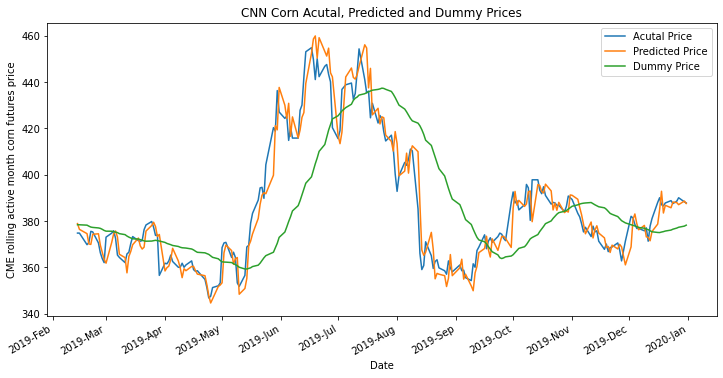

In [15]:
plotter = Security_Plotter(in_data, actual_price, predicted_price,
                            dummy_price, in_data.train_len, window_len, in_str, model_str)

plotter.single_plot()

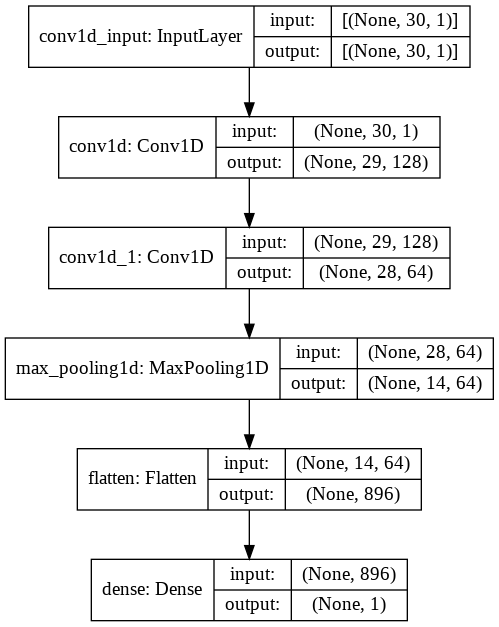

In [16]:
plot_model(model, show_shapes=True, expand_nested=True)

In [17]:
# calculating mean squared error
mse = mean_squared_error(y_true, y_pred)
d_mse = mean_squared_error(y_true, y_dummy)

# calculating root mean squared error
rmse = mean_squared_error(y_true, y_pred, squared=False)
d_rmse = mean_squared_error(y_true, y_dummy, squared=False)

# calculating mean absolute error
mae = mean_absolute_error(y_true, y_pred)
d_mae = mean_absolute_error(y_true, y_dummy)

print('MSE: ', mse)
print('RMSE: ', rmse)
print('MAE: ', mae)
print('Dummy MSE: ', d_mse)
print('Dummy RMSE: ', d_rmse)
print('Dummy MAE: ', d_mae)

MSE:  0.0045809939005645815
RMSE:  0.0676830399772689
MAE:  0.048404493973573985
Dummy MSE:  0.041446864361575214
Dummy RMSE:  0.20358502980714277
Dummy MAE:  0.15160472972972977


In [18]:
# creating a string to save the model based on model name
save_path = '/content/gdrive/My Drive/models/'+model_str+'_'+in_str+'/'
# mounting google drive for easy storage of model
from google.colab import drive
# mounting the drive
drive.mount('/content/gdrive/')
# making the relevant directory to store the model
os.mkdir(save_path)
# saving the model
keras.models.save_model(model, save_path)
# saving the model graph
model_graph = plot_model(model, to_file=save_path+model_str+'_'+in_str+'_graph_.png', show_shapes=True, expand_nested=True)
# saving the matplotlib plot
plotter.fig.savefig(save_path+model_str+'_'+in_str+'_plot.png', bbox_inches='tight')
# saving the error metrics as a text file
error_file = open(save_path+model_str+'_'+in_str+'_metrics.txt', 'w+')
error_file.write('MSE: '+str(mse)+'\n'+'RMSE: '+str(rmse)+'\n'+'MAE: '+str(mae)+'\n'+
                 'Dummy MSE: '+str(d_mse)+'\n'+'Dummy RMSE: '+str(d_rmse)+'\n'+'Dummy MAE: '+str(d_mae))
error_file.close()

Mounted at /content/gdrive/
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/CNN_Corn/assets
